# Importing Data

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
#from coffea.util import load
import numpy as np
import pandas as pd
import awkward as ak
#from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from numba import njit
import vector
vector.register_numba()
vector.register_awkward()


from pprint import pprint 
hep.style.use(hep.style.ROOT)

import hist

In [2]:
#df = ak.from_parquet("/eos/user/d/dvalsecc/www/ttHbbAnalysis/training_dataset/all_jets_v6.parquet")
df = ak.from_parquet("../MEMFlow/dataset/all_jets_v7.parquet")

In [3]:
(jets,
partons_matched,
partons,
generator_info,
lepton_partons,
lepton_reco, 
met,
higgs
) = ak.unzip(df)

jets = ak.with_name(jets, name="Momentum4D")
partons_matched = ak.with_name(partons_matched, name="Momentum4D")
partons = ak.with_name(partons, name="Momentum4D")
lepton_partons = ak.with_name(lepton_partons, name="Momentum4D")
lepton_reco = ak.with_name(lepton_reco, name="Momentum4D")
met = ak.with_name(met, name="Momentum4D")
higgs = ak.with_name(higgs, name="Momentum4D")

# Provenance flag

The provenance flag is defined in https://github.com/PocketCoffea/PocketCoffea/blob/main/pocket_coffea/lib/parton_provenance.py#L7 

- 1=higgs,
- 2=hadronic top bquark,
- 3=leptonic top bquark,
- 4=additional radiation
- 5=hadronic W (from top) decay quarks

# Example

In [ ]:
jets.pt > 70

<Array [[False, False, ..., False, False], ...] type='584143 * var * bool'>

In [ ]:
jets[jets.pt > 60]

<MomentumArray4D [[{pt: 68.3, eta: 0.853, ...}], ...] type='584143 * var * ...'>

# Exercise Plots

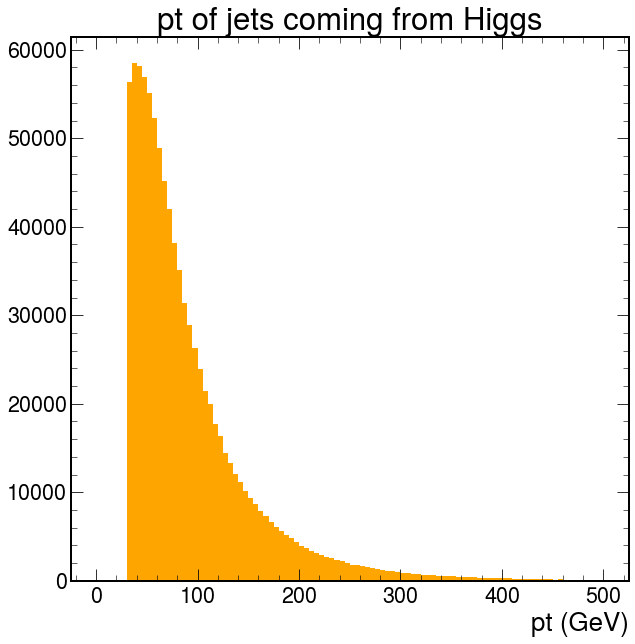

In [113]:
#find jets with provenance 1
prov1_jets = jets[jets.prov == 1]

#plot the transverse momenta of these jets
plt.hist(ak.flatten(prov1_jets.pt), bins=100, range=(0, 500), color="orange")
plt.title("pt of jets coming from Higgs")
plt.xlabel("pt (GeV)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/pt_from_higgs.png")
plt.show()

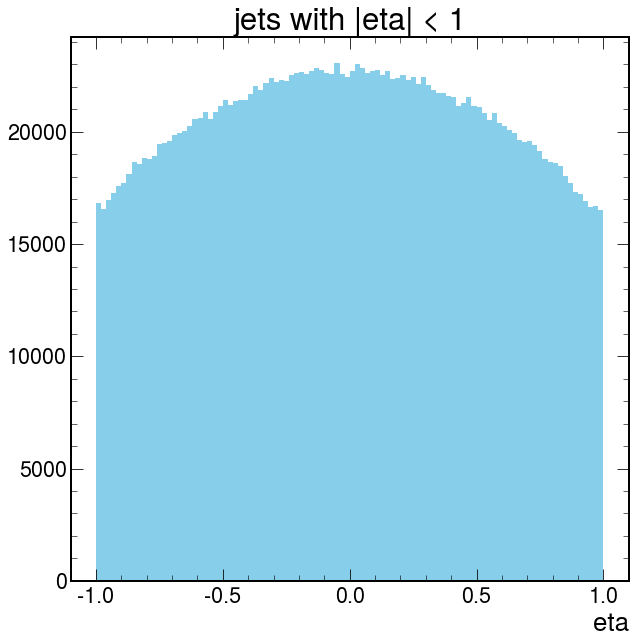

In [114]:
#find jets with |eta|<1
smalleta_jets = jets[np.abs(jets.eta) < 1.0]

#plot the eta of these jets
plt.hist(ak.flatten(smalleta_jets.eta), bins=100, color="skyblue")
plt.xlabel("eta")
plt.title("jets with |eta| < 1")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/small_eta_jets.png")
plt.show()

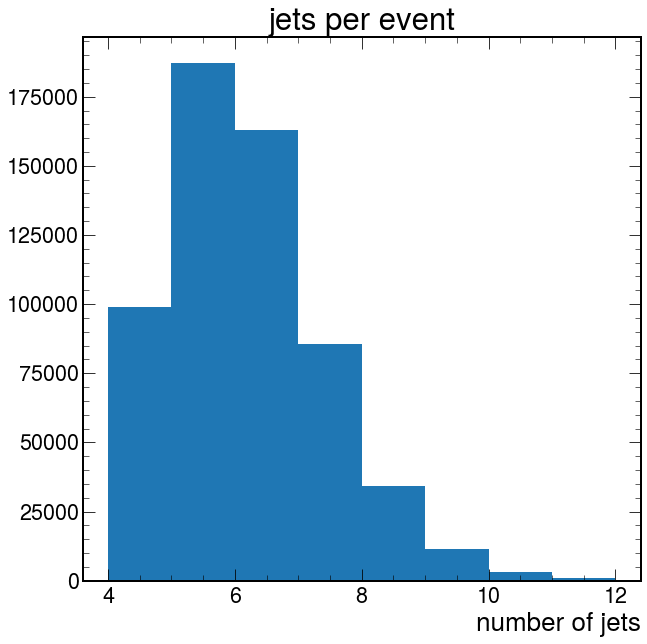

In [115]:
#count number of jets per event
jetnum = ak.num(jets.pt, axis=1)
plt.hist(jetnum, bins=8, range=(4,12))
plt.title("jets per event")
plt.xlabel("number of jets")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/jets_per_event")
plt.show()

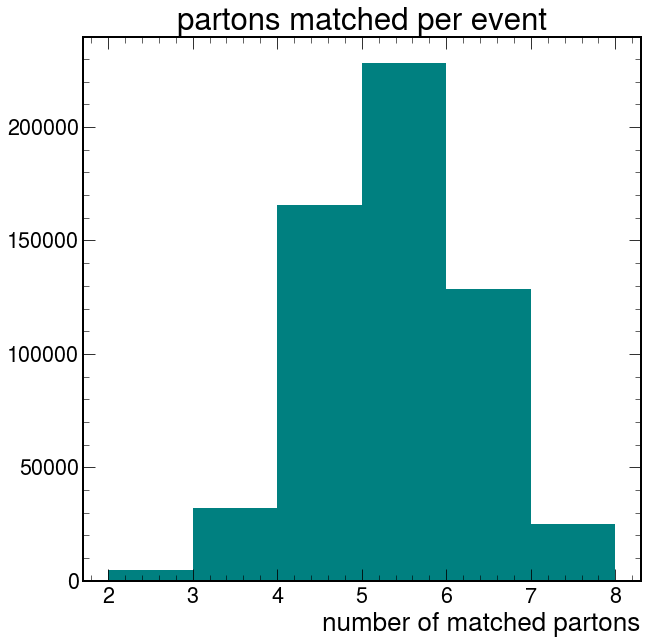

In [116]:
#count number of matched partons per event
partons_knownprov = partons_matched[jets.prov != -1]
matchednum = ak.num(partons_knownprov.prov, axis=1)
plt.hist(matchednum, bins=6, range=(2,8), color="teal")
plt.title("partons matched per event")
plt.xlabel("number of matched partons")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/matched_partons_per_event")
plt.show()

In [117]:
#count number of events with 2 matched jets coming from higgs (prov = 1)
jets_higgs = jets[jets.prov == 1]
jets_2higgs = jets_higgs[ak.num(jets_higgs.pt, axis=1) == 2]
eventnum_2higgs = ak.num(jets_2higgs.pt, axis=0)
eventnum_2higgs

350930

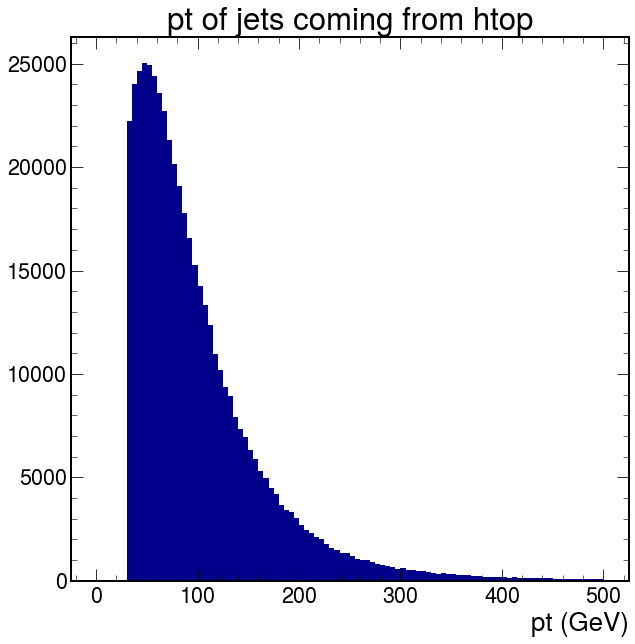

In [118]:
#find jets coming from hadronic top (prov = 2)
jets_htop = jets[jets.prov == 2]

#plot pt of these jets
plt.hist(ak.flatten(jets_htop.pt), bins=100, color="darkblue", range=(0,500))
plt.title("pt of jets coming from htop")
plt.xlabel("pt (GeV)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Exercise Plots/pt_from_htop")
plt.show()

# Invariant Mass

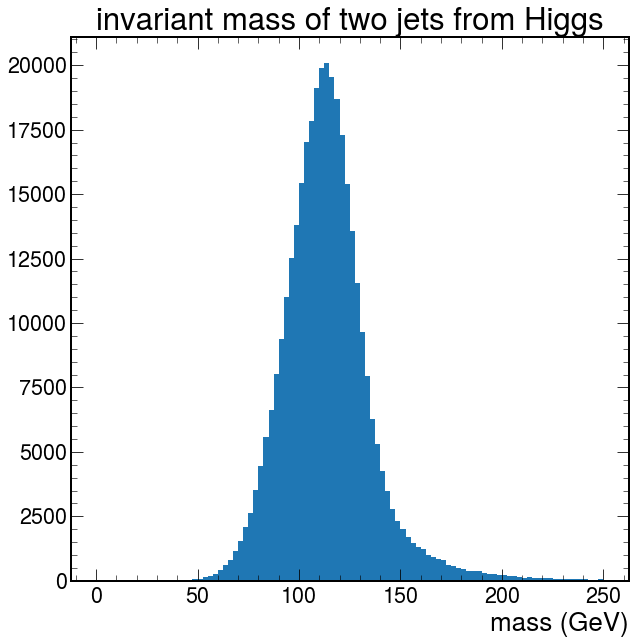

In [119]:
#invariant mass of two jets coming from higgs
summed_jets_higgs = jets_2higgs[:,0] + jets_2higgs[:,1]
plt.hist(summed_jets_higgs.mass, bins=100, range=(0,250))
plt.title("invariant mass of two jets from Higgs")
plt.xlabel("mass (GeV)")
plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/higgs_invariant_mass")
plt.show()

In [4]:
def generate_summed(jets, partons, prov):
    jets_prov = jets[jets.prov == prov]
    jets_2prov = jets_prov[ak.num(jets_prov.pt, axis=1) == 2]
    summed_jets_prov = jets_2prov[:,0] + jets_2prov[:,1]
    
    partons_prov = partons[jets.prov == prov]
    partons_2prov = partons_prov[ak.num(partons_prov.pt, axis=1) == 2]
    summed_partons_prov = partons_2prov[:,0] + partons_2prov[:,1]
    return summed_jets_prov, summed_partons_prov

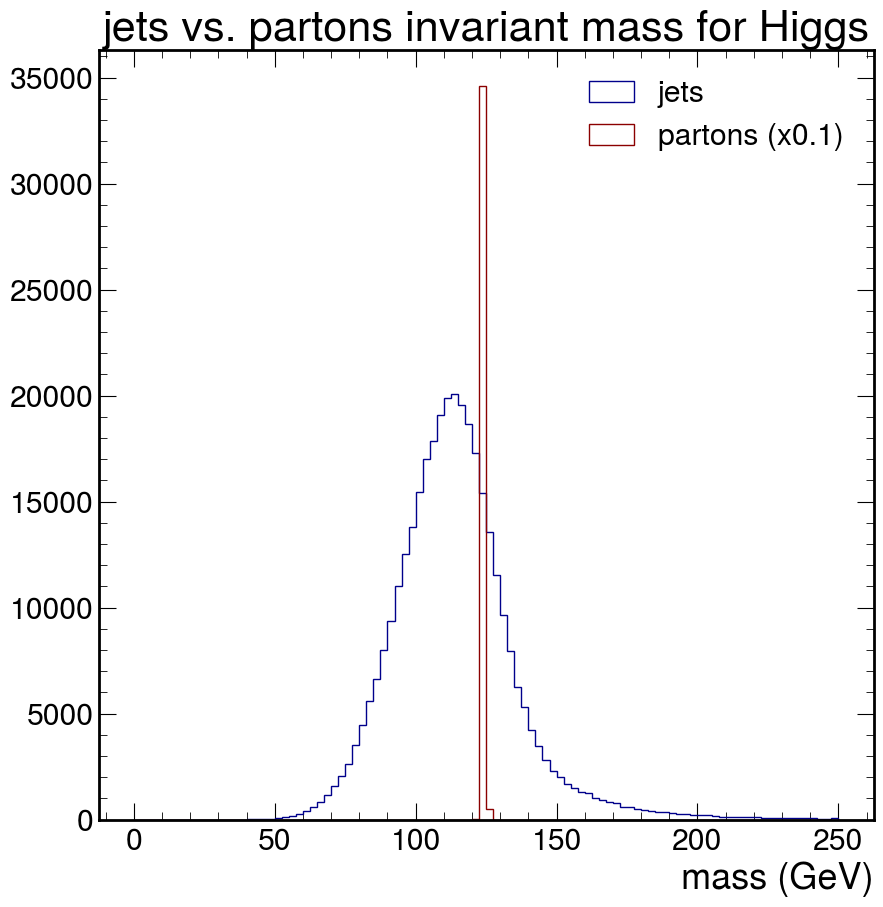

In [6]:
#invariant mass of the sum of the two jets associated with the Higgs
summed_jets_higgs, summed_partons_higgs = generate_summed(jets, partons_matched, 1)
plt.hist(summed_jets_higgs.mass, bins=100, range=(0,250), color="darkblue", histtype="step", label="jets")

#invariant mass of the sum of the two partons associated with the Higgs
plt.hist(summed_partons_higgs.mass, bins=100, weights=0.1*np.ones_like(summed_partons_higgs.mass), range=(0,250), color="darkred", histtype="step", label="partons (x0.1)")
plt.title("jets vs. partons invariant mass for Higgs")
plt.legend()
plt.xlabel("mass (GeV)")
#plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/jets_vs_partons_higgs")
plt.show()

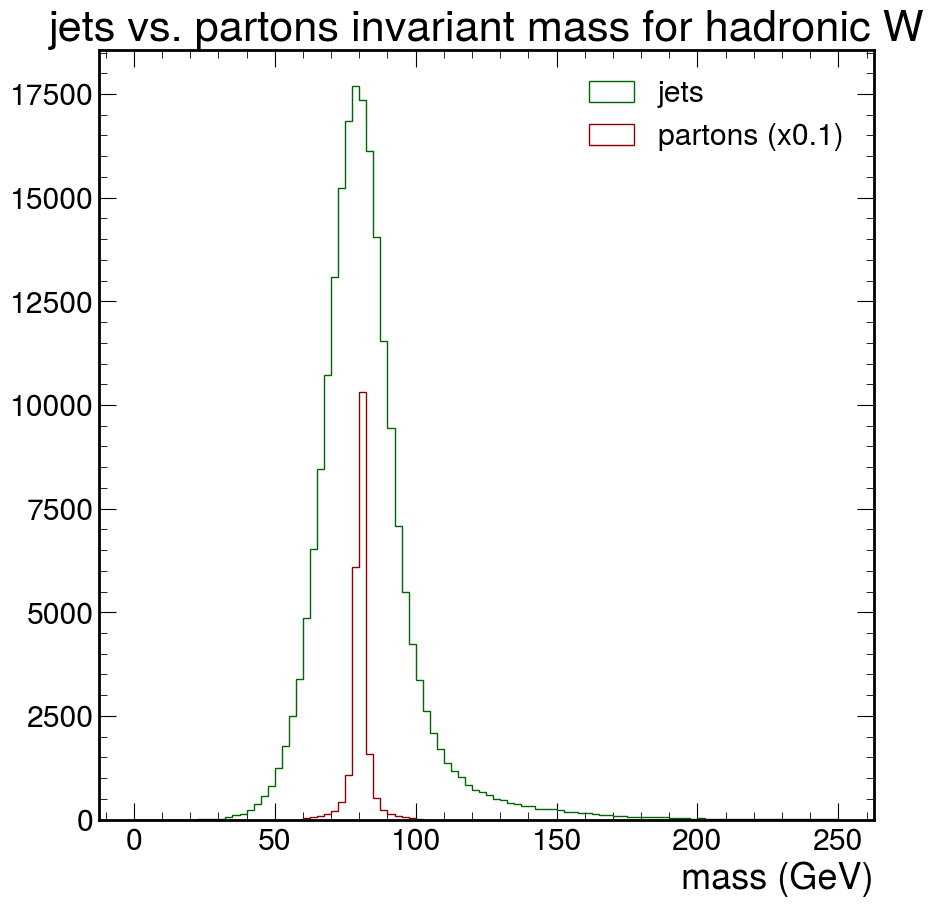

In [7]:
#invariant mass of the sum of the two jets associatied with the hadronically decaying W boson (prov = 5)

summed_jets_W, summed_partons_W = generate_summed(jets, partons_matched, 5)
plt.hist(summed_jets_W.mass, bins=100, range=(0,250), color="darkgreen", label=("jets"), histtype="step")

#invariant mass of the sum of the two partons associatied with the hadronically decaying W boson (prov = 5)
plt.hist(summed_partons_W.mass, weights=0.1*np.ones_like(summed_partons_W.mass), bins=100, range=(0,250), color="darkred", label=("partons (x0.1)"), histtype="step")
plt.title("jets vs. partons invariant mass for hadronic W")
plt.xlabel("mass (GeV)")
plt.legend()
#plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/jets_vs_partons_W")
plt.show()


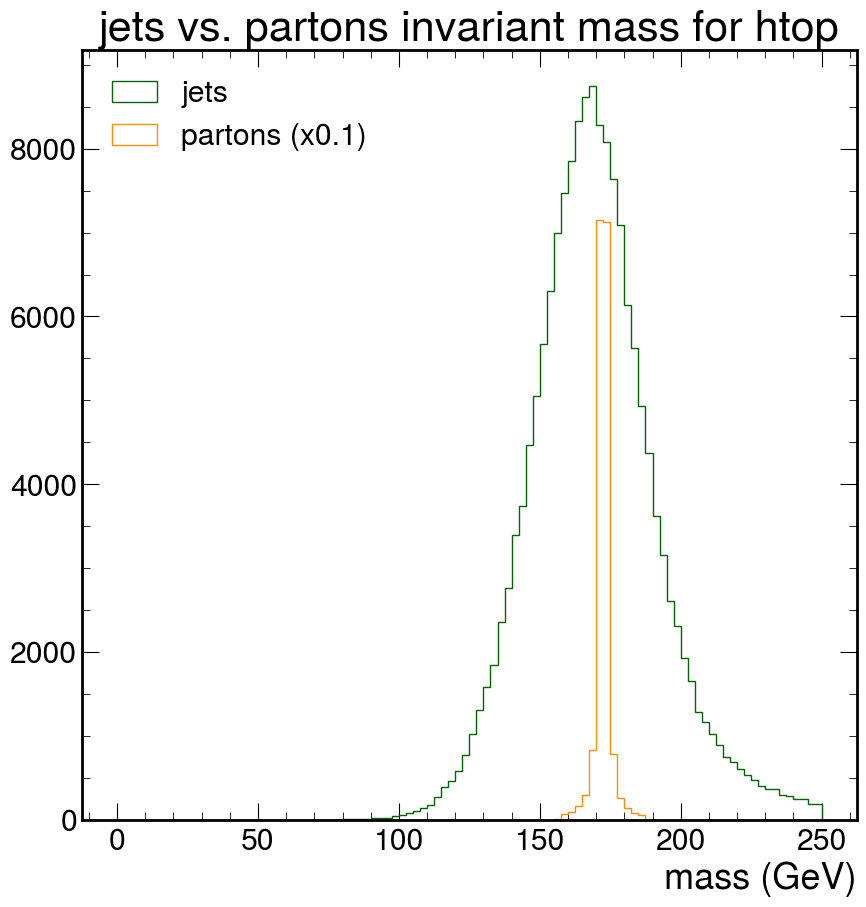

In [8]:
#invariant mass of top hadronically decaying
jets_with_2W = jets[ak.sum(jets.prov == 5, axis=1) == 2]
jets_with_1htop2W = jets_with_2W[ak.sum(jets_with_2W.prov == 2, axis=1) == 1]

partons_with_2W = partons_matched[ak.sum(jets.prov == 5, axis=1) == 2]
partons_with_1htop2W = partons_with_2W[ak.sum(jets_with_2W.prov == 2, axis=1) == 1]

summed_jets_W, summed_partons_W = generate_summed(jets_with_1htop2W, partons_with_1htop2W, 5)

jets_htop = jets_with_1htop2W[jets_with_1htop2W.prov == 2]
jets_1htop = jets_htop[ak.num(jets_htop.pt, axis=1) == 1]
summed_jets_htop = jets_1htop
    
partons_htop = partons_with_1htop2W[jets_with_1htop2W.prov == 2]
partons_1htop = partons_htop[ak.num(partons_htop.pt, axis=1) == 1]
summed_partons_htop = partons_1htop

total_sum_jets = summed_jets_W + summed_jets_htop
total_sum_partons = summed_partons_W + summed_partons_htop

plt.hist(total_sum_jets.mass, bins=100, range=(0,250), color="darkgreen", label="jets", histtype="step")
plt.hist(total_sum_partons.mass, weights=0.1*np.ones_like(total_sum_partons.mass), bins=100, range=(0,250), color="darkorange", label="partons (x0.1)", histtype="step")
plt.title("jets vs. partons invariant mass for htop")
plt.legend(loc="upper left")
plt.xlabel("mass (GeV)")
#plt.savefig("/eos/user/m/mamantov/ttHbb_jets_partons_studies/Plots/Invariant Mass/jets_vs_partons_htop")
plt.show()

# Higgs Correlations

In [9]:
#selects events which include a given provenance (particle) with a certain multiplicity.
#provs: array of provenances;   mults: corresponding multiplicities
def select_include(jets, partons, provs, mults):
    new_jets = jets
    new_partons = partons
    for (prov, mult) in zip(provs, mults):
        if mult == -1:
            mask = (ak.sum(new_jets.prov == prov, axis=1) != 0)
            new_jets = new_jets[mask]
            new_partons = new_partons[mask]
        else:
            mask = (ak.sum(new_jets.prov == prov, axis=1) == mult)
            new_jets = new_jets[mask]
            new_partons = new_partons[mask]
    return new_jets, new_partons

#selects only those jets/partons of a given provenance (particle)
def select_only(jets, partons, prov):
    new_jets = jets[jets.prov == prov]
    new_partons = partons[jets.prov == prov]
    return new_jets, new_partons


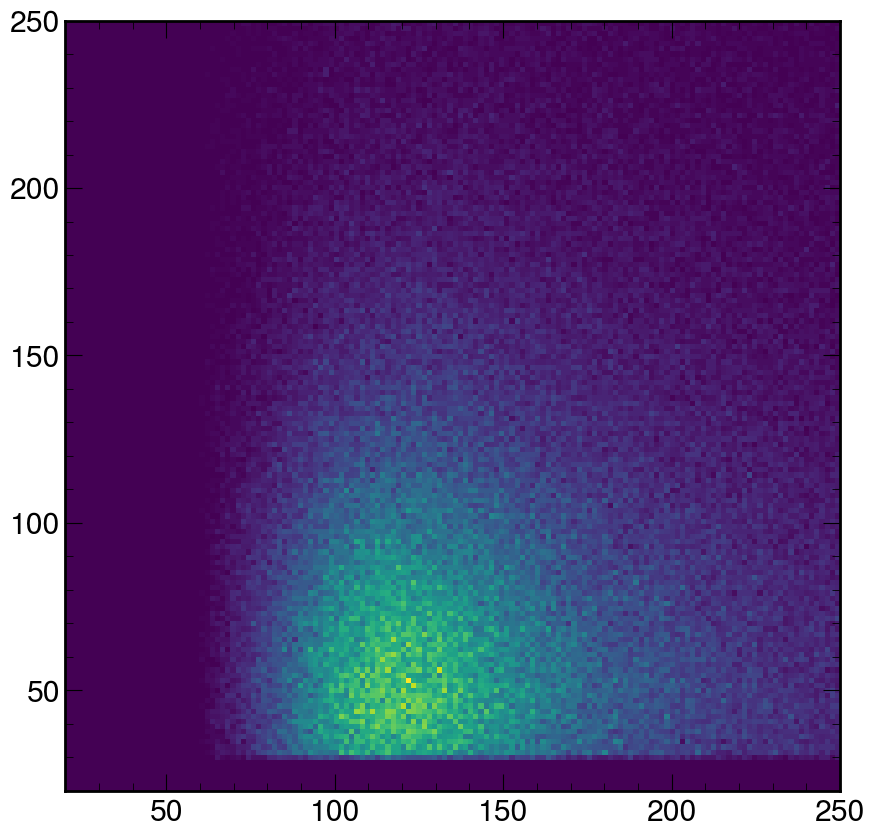

In [19]:
#previous example with new functions
jets_with_2higgs1htop, partons_with_2higgs1htop = select_include(jets, partons_matched, [1, 2], [2, 1])
higgs_jets, higgs_partons = select_only(jets_with_2higgs1htop, partons_with_2higgs1htop, 1)
htop_jets, htop_partons = select_only(jets_with_2higgs1htop, partons_with_2higgs1htop, 2)
higgs_pt = ak.sum(higgs_jets.pt, axis=1)
htop_pt = ak.sum(htop_jets.pt, axis=1)

plt.hist2d(ak.to_numpy(higgs_pt), np.asarray(htop_pt), bins=(150,150), range=[[20, 250], [20, 250]])
plt.show()

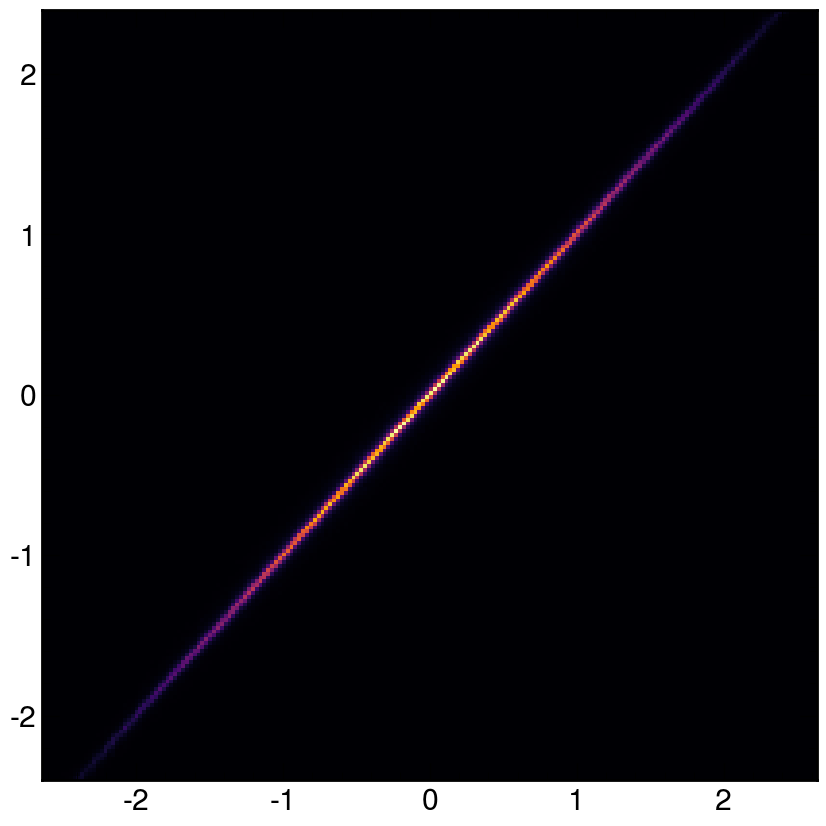

In [21]:
#eta of higgs vs eta of partons
higgs_jets, higgs_partons = select_only(jets, partons_matched, 1)
jet_eta = higgs_jets.eta
parton_eta = higgs_partons.eta
jet_eta = ak.flatten(jet_eta)
parton_eta = ak.flatten(parton_eta)

plt.hist2d(np.asarray(parton_eta), np.asarray(jet_eta), bins=(200,200), cmap="inferno")
plt.show()

# Boost

In [7]:
@njit
def sum_vectors_all(arrays):
    size = len(arrays)
    results = np.zeros((size, 4))
    for i, array in enumerate(arrays):
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in array:
            total = total + v
        results[i, 0] = total.px
        results[i, 1] = total.py
        results[i, 2] = total.pz
        results[i, 3] = total.E
    return results


def get_vector_sum(vectors):
    out = sum_vectors_all(vectors)
    return vector.awk({
        "px": out[:, 0],
        "py": out[:, 1],
        "pz": out[:, 2],
        "E": out[:, 3],
    })

In [23]:
boost_jets = get_vector_sum(jets)
boost_reco = boost_jets + lepton_reco + met

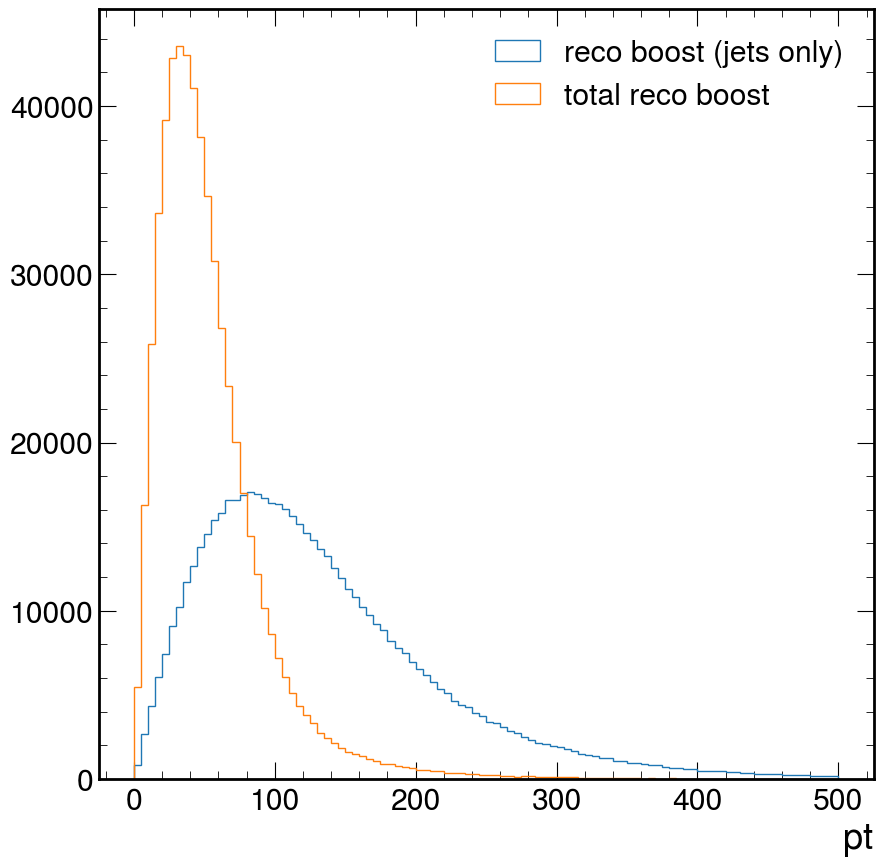

In [24]:
plt.hist(boost_jets.pt, bins=100, label="reco boost (jets only)", range=(0, 500), histtype="step")
plt.hist(boost_reco.pt, bins=100, label="total reco boost",range=(0, 500), histtype="step")
plt.xlabel("pt")
plt.legend()
plt.show()

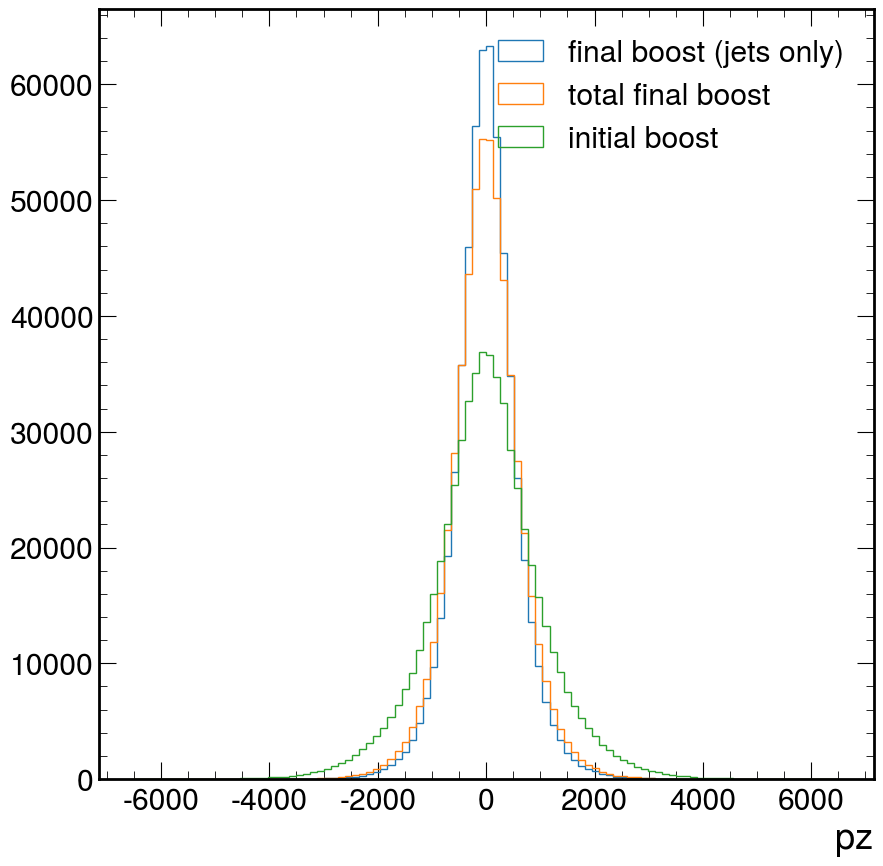

In [25]:
plt.hist(boost_jets.pz, bins=100, label="final boost (jets only)", range=(-6500, 6500), histtype="step")
plt.hist(boost_reco.pz, bins=100, label="total final boost",range=(-6500, 6500), histtype="step")
plt.hist(generator_info.x1 * 6500 - generator_info.x2 * 6500, bins=100, label="initial boost",range=(-6500, 6500), histtype="step" )
plt.legend()
plt.xlabel("pz")
plt.show()

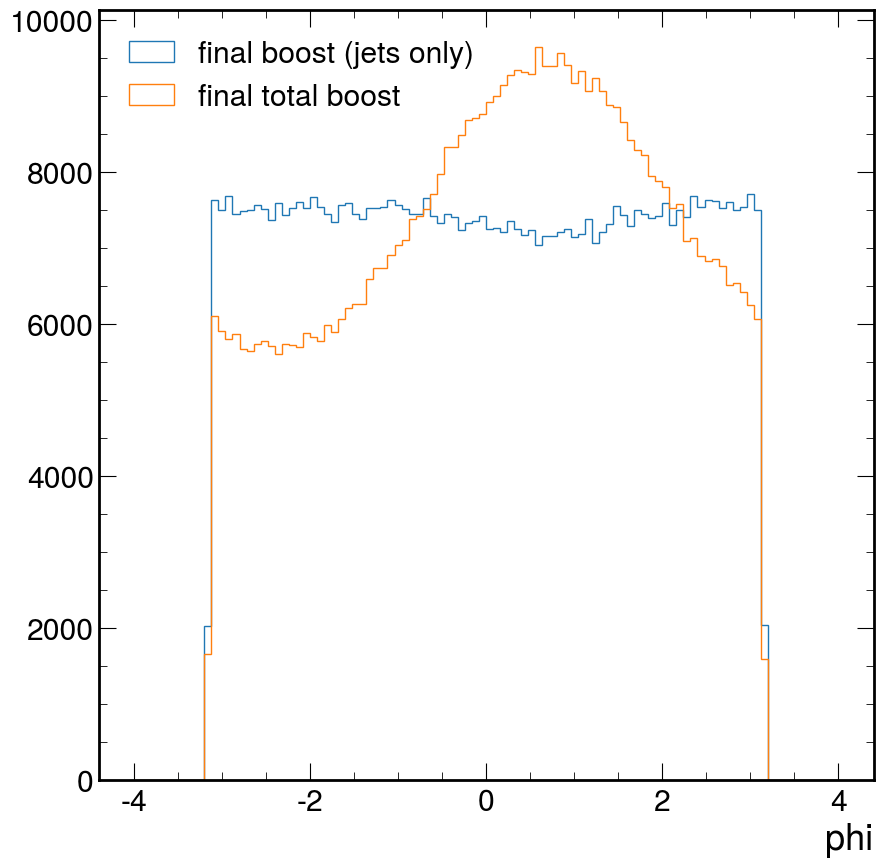

In [26]:
plt.hist(boost_jets.phi, bins=100, label="final boost (jets only)", range=(-4, 4), histtype="step")
plt.hist(boost_reco.phi, bins=100, label="final total boost", range=(-4, 4), histtype="step")
plt.xlabel("phi")
plt.legend(loc="upper left")
plt.show()

# Partons boost

In [42]:
parton_boost_nolepton = get_vector_sum(partons)
parton_boost_lepton = get_vector_sum(lepton_partons)
parton_boost = parton_boost_nolepton + parton_boost_lepton

In [43]:
total_boost = parton_boost

In [59]:
parton_boosted =  parton_boost.boost_p4(total_boost.neg3D)
parton_boost_lepton_boosted =  parton_boost_lepton.boost_p4(total_boost.neg3D)

In [61]:
tot = parton_boosted + parton_boost_lepton_boosted

In [67]:
getattr(tot, "pt")

<Array [63.2, 156, 123, 293, ..., 72.3, 179, 65.7, 166] type='584143 * float64'>

In [68]:
tot.pt

<Array [63.2, 156, 123, 293, ..., 72.3, 179, 65.7, 166] type='584143 * float64'>

### Removal of additional gluon

In [4]:
x1_numpy = generator_info.x1.to_numpy()
x2_numpy = generator_info.x2.to_numpy()

pz = (x1_numpy - x2_numpy) * 6500.0
E = (x1_numpy + x2_numpy) * 6500.0
zeros = np.zeros(pz.shape)

incoming_particles_boost = ak.Array(
    {
        "x": zeros,
        "y": zeros,
        "z": pz,
        "t": E,
    }
)

incoming_particles_boost = ak.with_name(incoming_particles_boost, name="Momentum4D")


In [5]:
incoming_particles_boost

<MomentumArray4D [{x: 0, y: 0, z: 807, t: 999}, ...] type='569993 * Momentu...'>

In [20]:
def Reshape(input, value, ax):
    max_no = ak.max(ak.num(input, axis=ax))
    input_padded = ak.pad_none(input, max_no, axis=ax)
    input_filled = ak.fill_none(input_padded, value, axis=ax)

    return input_filled

In [45]:
gluon = partons[partons.prov == 4]
struct_partons = ak.zip({"pt": np.float32(0),
                         "eta": np.float32(0),
                         "phi": np.float32(0),
                         "mass": np.float64(0),
                         "pdgId": bool(0),
                         "prov": -1},
                        with_name='Momentum4D')

gluon = Reshape(gluon, struct_partons, 1)[:, 0]

# For the moment, removing the additional gluon
# from the incoming particles momenta and from the final particle boost
boost = incoming_particles_boost - gluon
incoming_particles_boost["z"] = incoming_particles_boost["z"] - gluon.pz
incoming_particles_boost["t"] = incoming_particles_boost["t"] - gluon.E


In [19]:
def boost_CM(objects_array, boost):
    objects_CM = objects_array.boost_p4(boost.neg3D)

    # Overwriting old pt by calling the function on the boosted object
    # overwrite objects_array because i dont like "objects_CM.type"
    objects_array["pt"] = objects_CM.pt
    objects_array["eta"] = objects_CM.eta
    objects_array["phi"] = objects_CM.phi

    return objects_array

In [47]:
partons_boosted = boost_CM(partons, boost)
lepton_boosted = boost_CM(lepton_reco, boost)
higgs_boosted = boost_CM(higgs, boost)

- 1=higgs,
- 2=hadronic top bquark,
- 3=leptonic top bquark,
- 4=additional radiation
- 5=hadronic W (from top) decay quarks

## Checks about the additional final state gluon

In [12]:
lep_top = partons[partons.prov== 3][:,0] + get_vector_sum(lepton_partons)
had_top = partons[partons.prov== 2][:,0] + partons[partons.prov== 5][:,0] + partons[partons.prov== 5][:,1]

Text(1, 0, 'system invariant mass [GeV]')

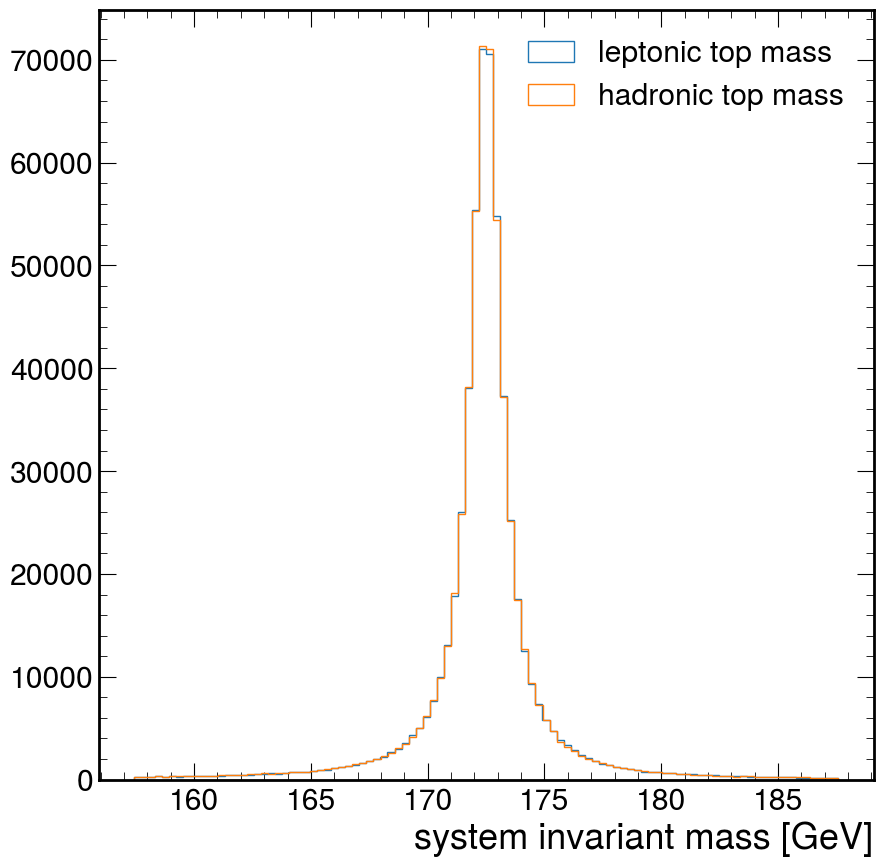

In [27]:
plt.hist(lep_top.m,bins=100, histtype="step", label="leptonic top mass")
plt.hist(had_top.m,bins=100, histtype="step", label="hadronic top mass")
#plt.hist(higgs.m,bins=100, histtype="step", label="higgs mass")
plt.legend()
plt.xlabel("system invariant mass [GeV]")

In [21]:
gluon = partons[partons.prov == 4]
struct_partons = ak.zip({"pt": np.float32(0),
                         "eta": np.float32(0),
                         "phi": np.float32(0),
                         "mass": np.float64(0),
                         "pdgId": bool(0),
                         "prov": -1},
                        with_name='Momentum4D')

gluon = Reshape(gluon, struct_partons, 1)[:, 0]


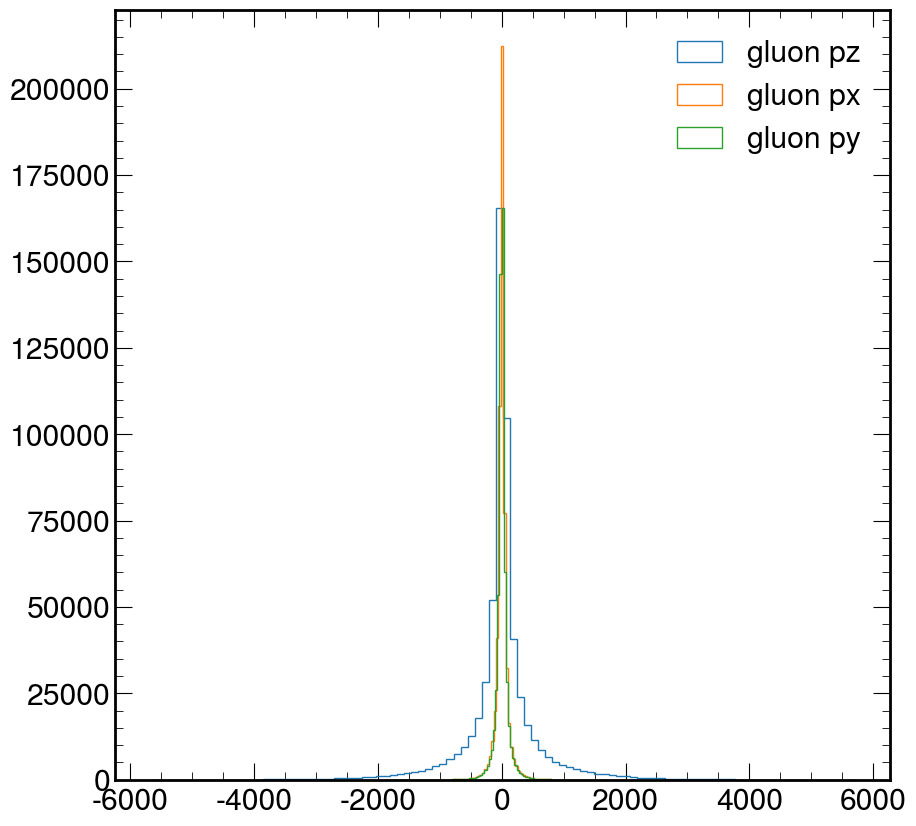

In [25]:
plt.hist(gluon.pz, bins=100, label="gluon pz", histtype="step",)
plt.hist(gluon.px, bins=100, label="gluon px", histtype="step",)
plt.hist(gluon.py, bins=100, label="gluon py", histtype="step",)
plt.legend()

In [28]:
sum_partons = lep_top + had_top + higgs + gluon

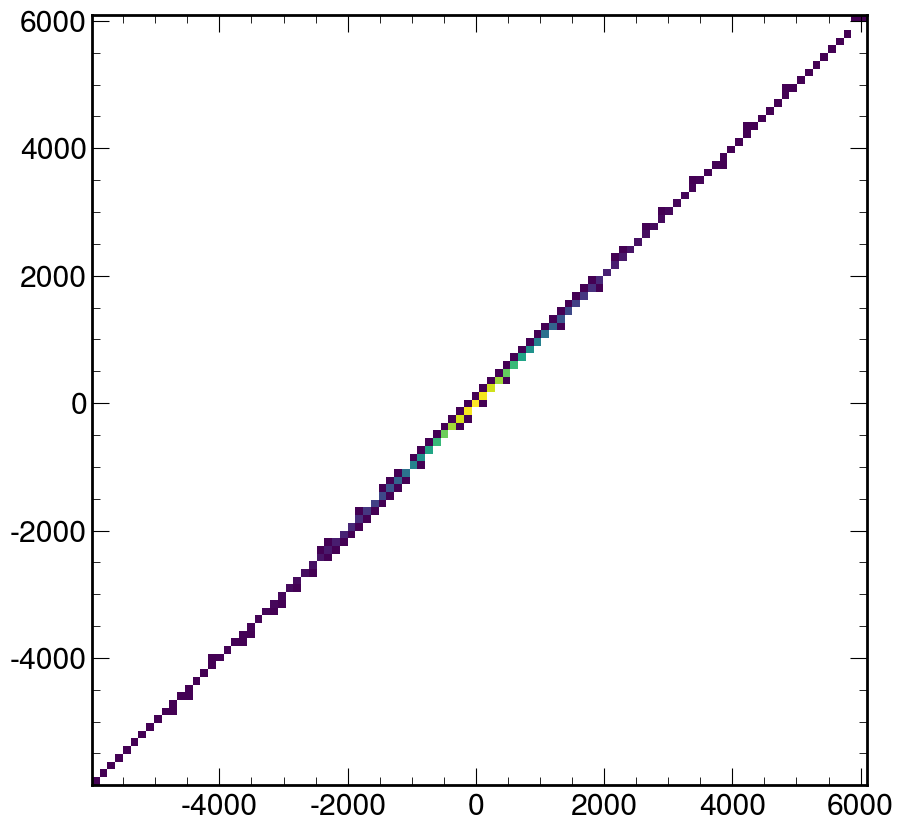

In [33]:
plt.hist2d(incoming_particles_boost.pz.to_numpy(), sum_partons.pz.to_numpy(), bins=100, cmin=1);

/tmp/ipykernel_80616/168479003.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.hist(sum_partons.pz.to_numpy()/incoming_particles_boost.pz.to_numpy(), bins=100, range=(0.999,1.001), label="pz", histtype="step");


Text(1, 0, 'ratio sumpartons/incoming particles')

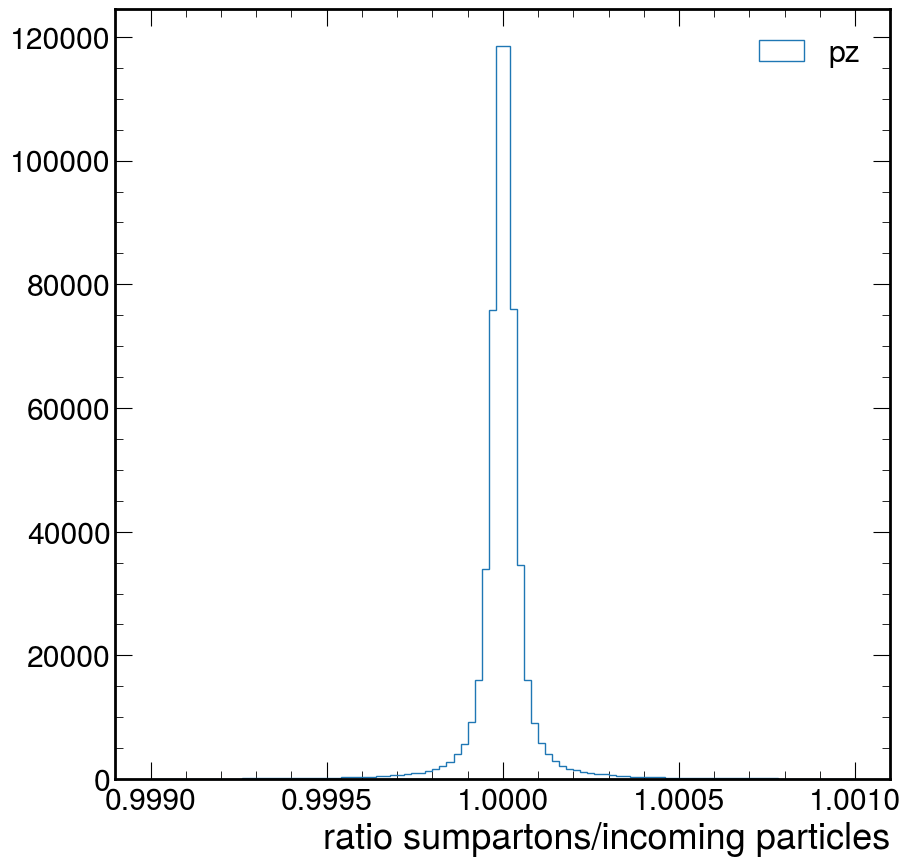

In [42]:
plt.hist(sum_partons.pz.to_numpy()/incoming_particles_boost.pz.to_numpy(), bins=100, range=(0.999,1.001), label="pz", histtype="step");
plt.legend()
plt.xlabel("ratio sumpartons/incoming particles")

Text(1, 0, 'sum partons momenta')

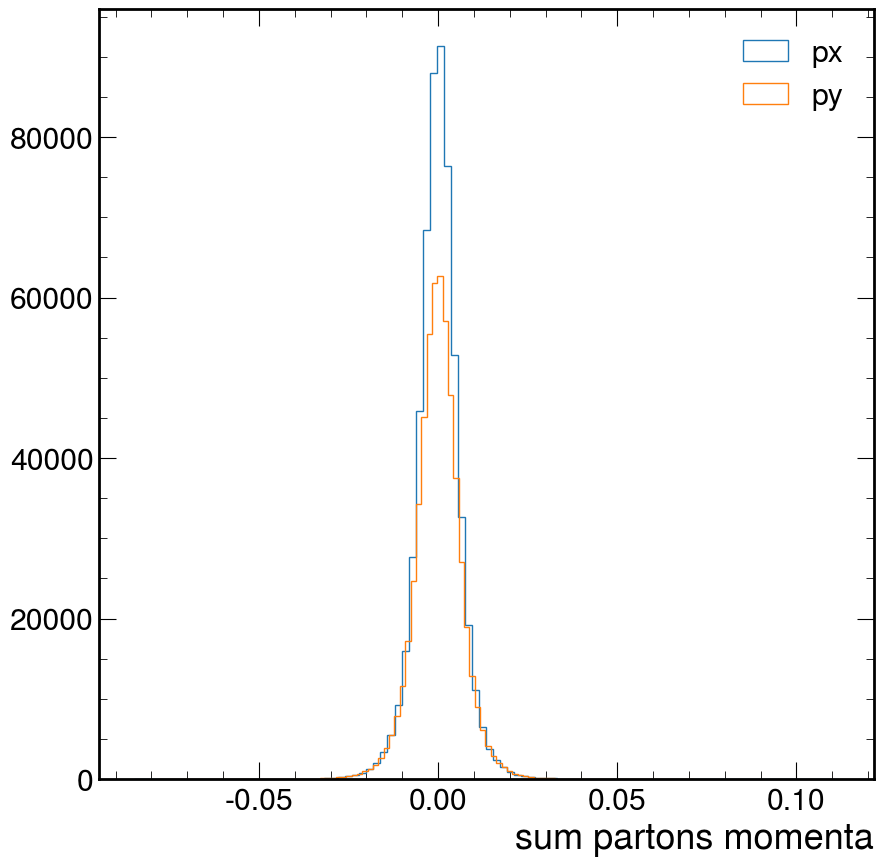

In [44]:
plt.hist(sum_partons.px.to_numpy(), bins=100, label="px", histtype="step");
plt.hist(sum_partons.py.to_numpy(), bins=100, label="py", histtype="step");
plt.legend()
plt.xlabel("sum partons momenta")

In [45]:
# remove the gluon from the initial state

incoming_minus_gluon = incoming_particles_boost - gluon
sum_partons_mins_gluon = lep_top + had_top + higgs

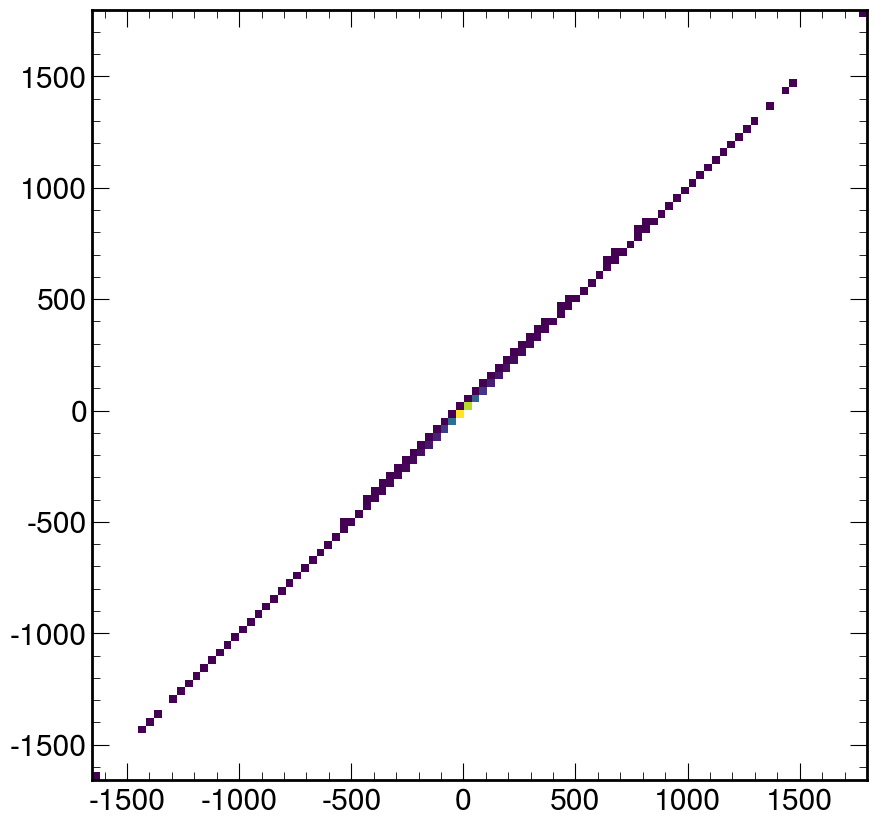

In [48]:
plt.hist2d(incoming_minus_gluon.py.to_numpy(), sum_partons_mins_gluon.py.to_numpy(), bins=100, cmin=1);

Text(0, 1, 'gluon pz')

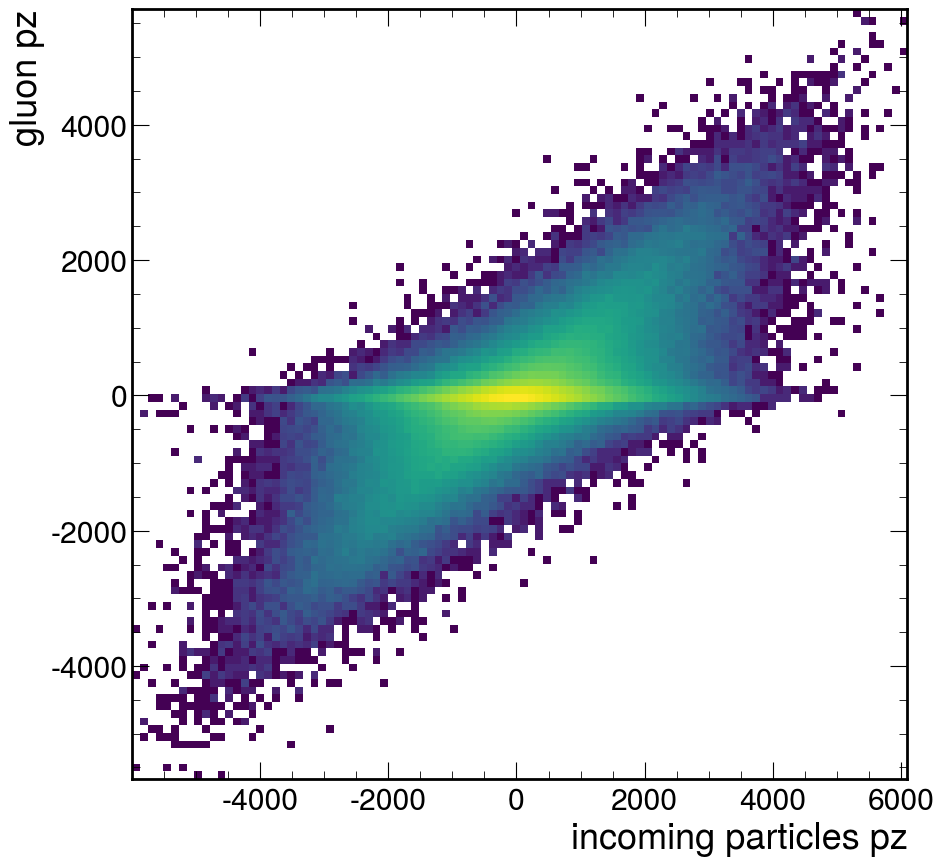

In [92]:
plt.hist2d(incoming_particles_boost.pz.to_numpy(), gluon.pz.to_numpy(), bins=100, norm=LogNorm());
plt.xlabel("incoming particles pz")
plt.ylabel("gluon pz")

Text(0, 1, 'gluon pz')

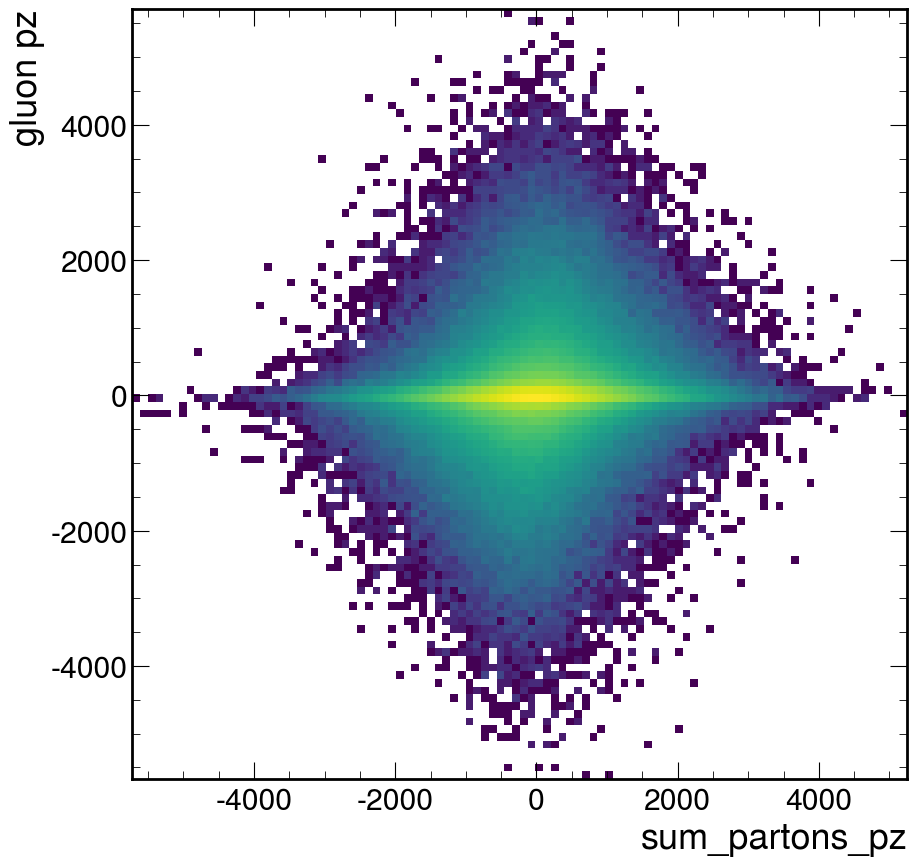

In [90]:
plt.hist2d(sum_partons_mins_gluon.pz.to_numpy(), gluon.pz.to_numpy(), bins=100, norm=LogNorm());
plt.xlabel("sum_partons_pz")
plt.ylabel("gluon pz")

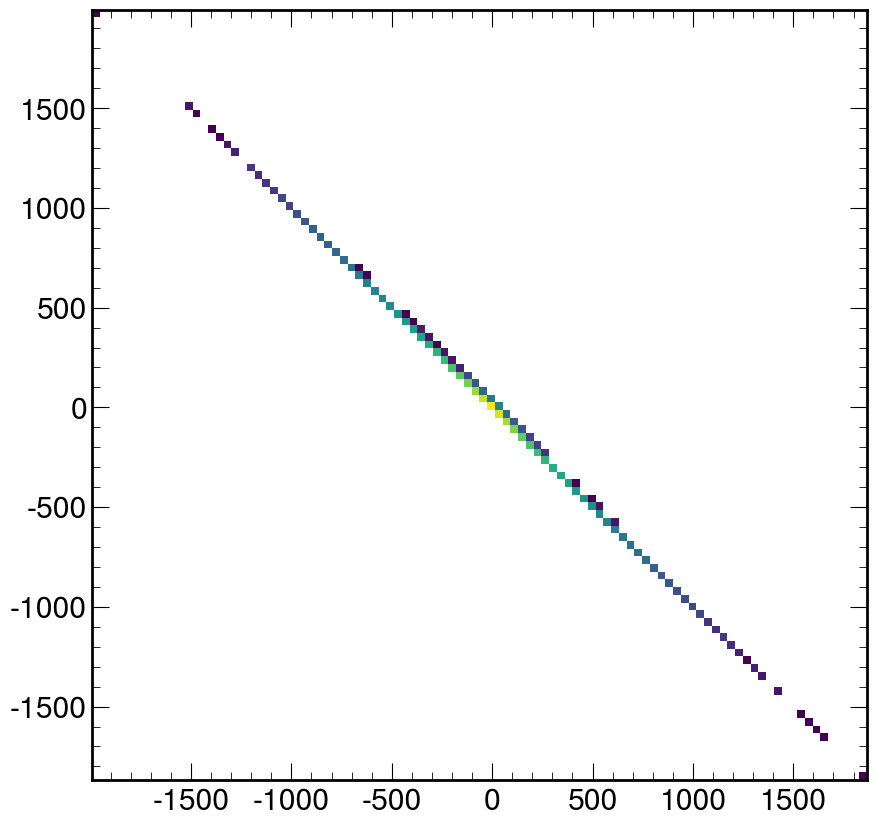

In [88]:
plt.hist2d(sum_partons_mins_gluon.px.to_numpy(), gluon.px.to_numpy(), bins=100, norm=LogNorm());
#plt.hist2d(sum_partons_mins_gluon.py.to_numpy(), gluon.py.to_numpy(), bins=100, norm=LogNorm());


In [63]:
gluon_xy = ak.with_name(ak.zip({"x": gluon.px, "y": gluon.py, "z": 0, "t": (gluon.px**2+ gluon.py**2)**0.5 }), name="Momentum4D")

In [57]:
gluon_xy.neg3D

<MomentumArray4D [{x: -28.3, y: -11.5, z: 0, ...}, ...] type='569993 * Mome...'>

In [73]:
# Now boost both in the -gluon_xy component to remove the xy component of the gluon
incoming_minus_gluon_boostxy = incoming_minus_gluon.boost_p4(gluon_xy.neg3D)

In [83]:
gluon_xy.neg3D[0].t

30.558593750000004

In [78]:
incoming_minus_gluon[0]

<MomentumRecord4D {x: -28.3, y: -11.5, z: 806, ...} type='Momentum4D[x: flo...'>

In [79]:
incoming_minus_gluon_boostxy[0]

<MomentumRecord4D {x: -8.38e+10, y: -3.41e+10, ...} type='Momentum4D[x: flo...'>

# Lepton & MET

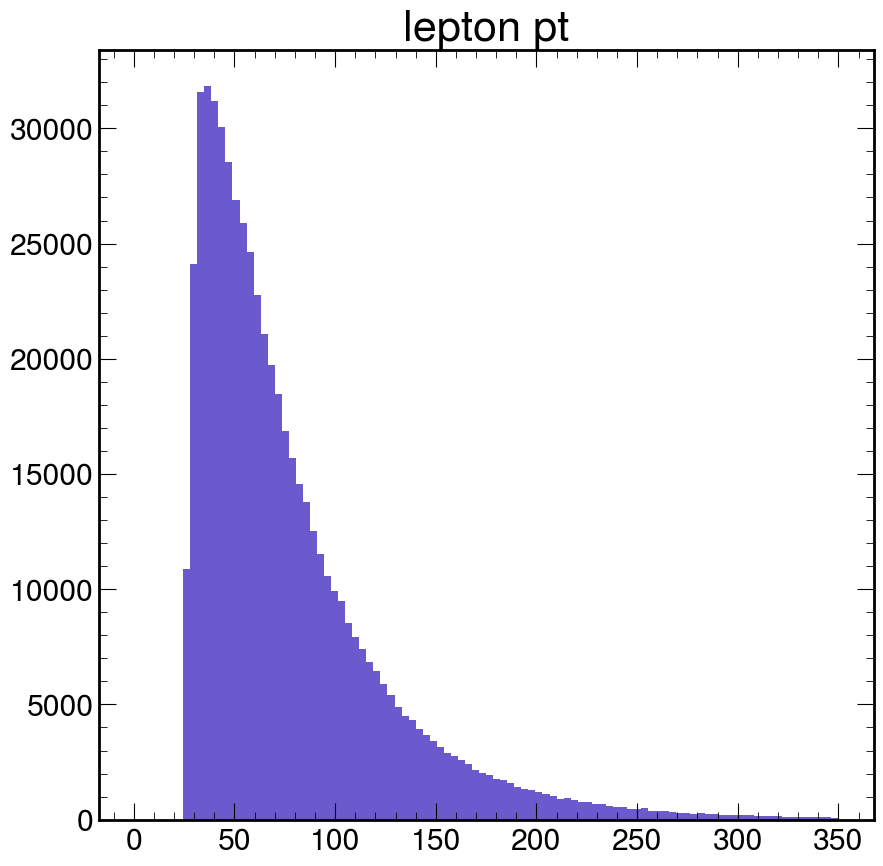

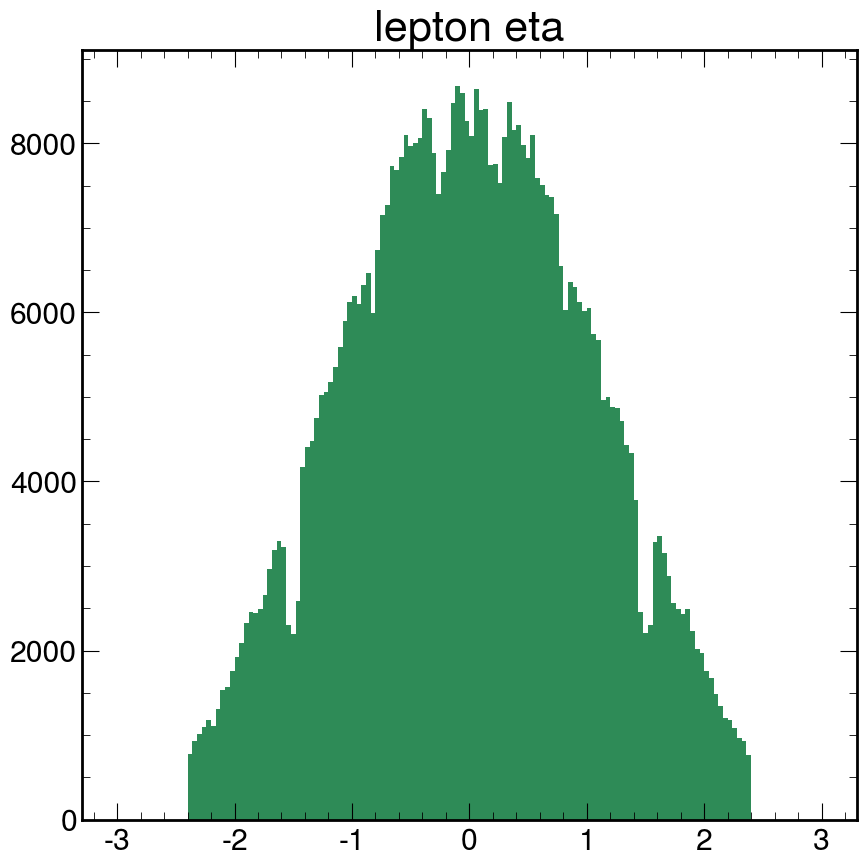

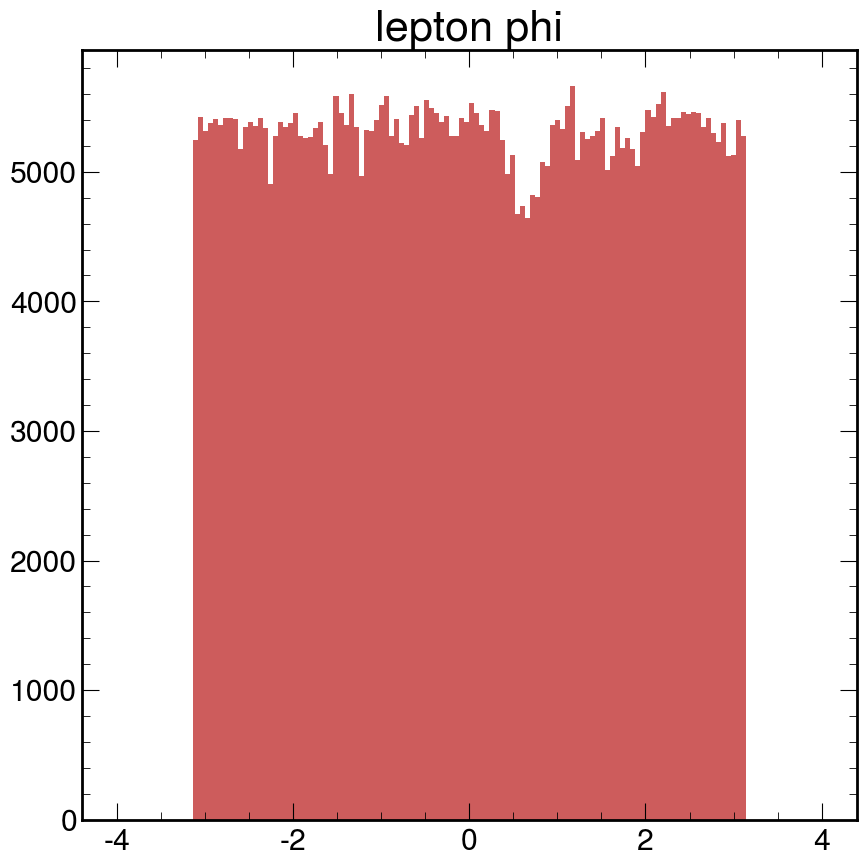

In [27]:
plt.hist(lepton_reco.pt, bins=100, range=(0,350), color="slateblue")
plt.title("lepton pt")
plt.show()
plt.hist(lepton_reco.eta, bins=150, range=(-3, 3), color="seagreen")
plt.title("lepton eta")
plt.show()
plt.hist(lepton_reco.phi, bins=140, range=(-4,4), color="indianred")
plt.title("lepton phi")
plt.show()


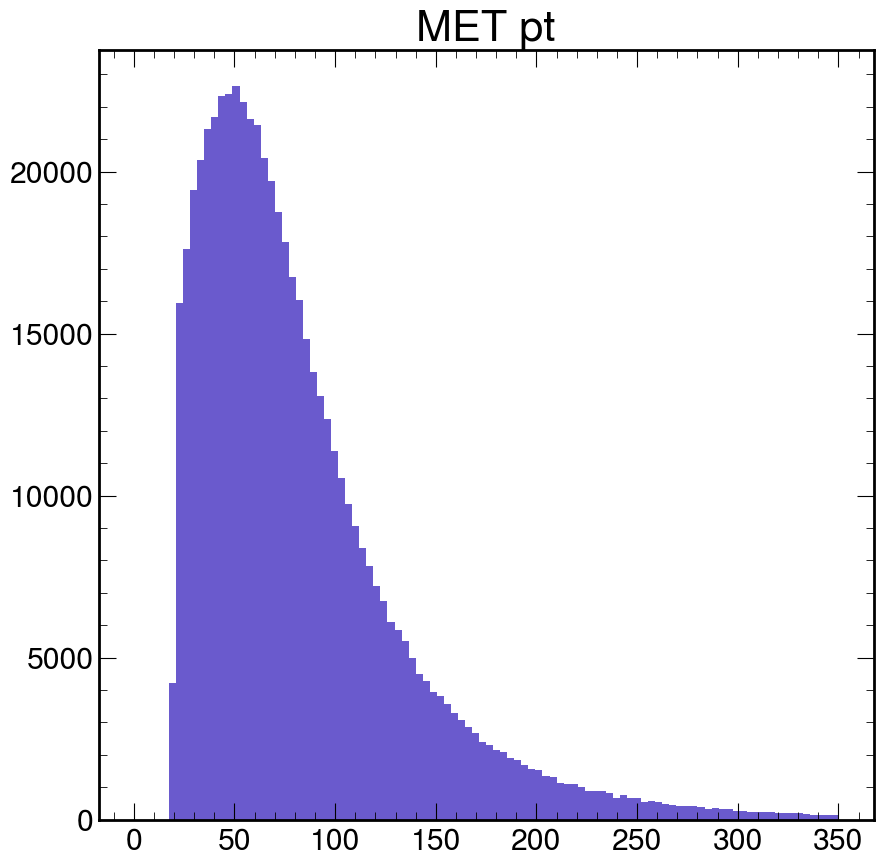

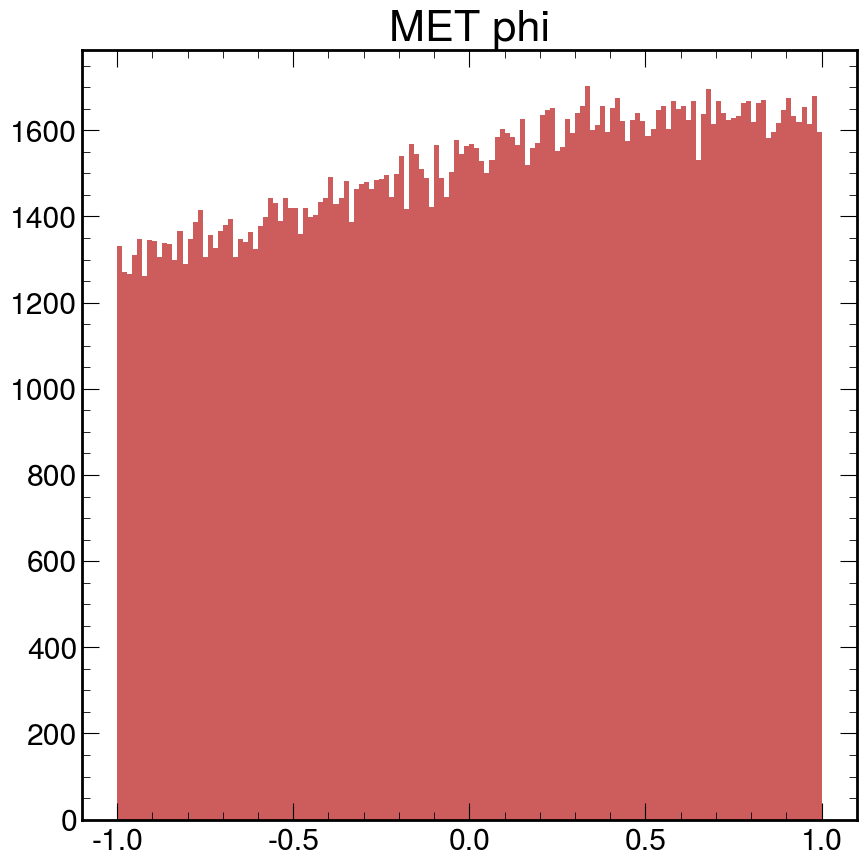

In [28]:
plt.hist(met.pt, bins=100, range=(0,350), color="slateblue")
plt.title("MET pt")
plt.show()
plt.hist(met.phi, bins=140, range=(-1, 1), color="indianred")
plt.title("MET phi")
plt.show()

# Correlation between lepton & MET

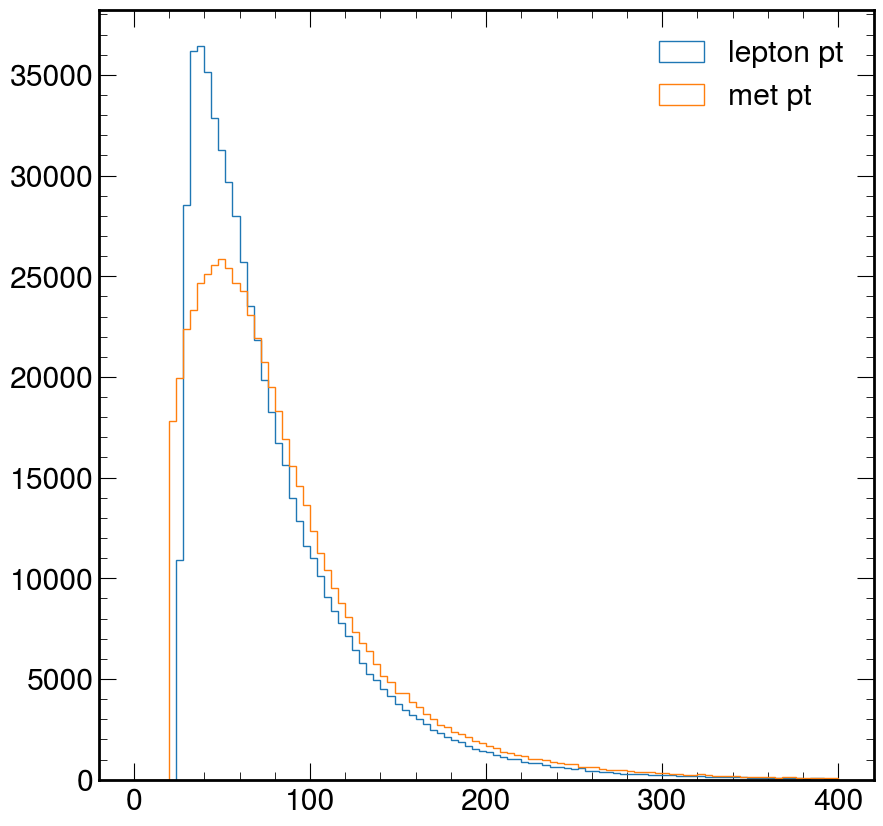

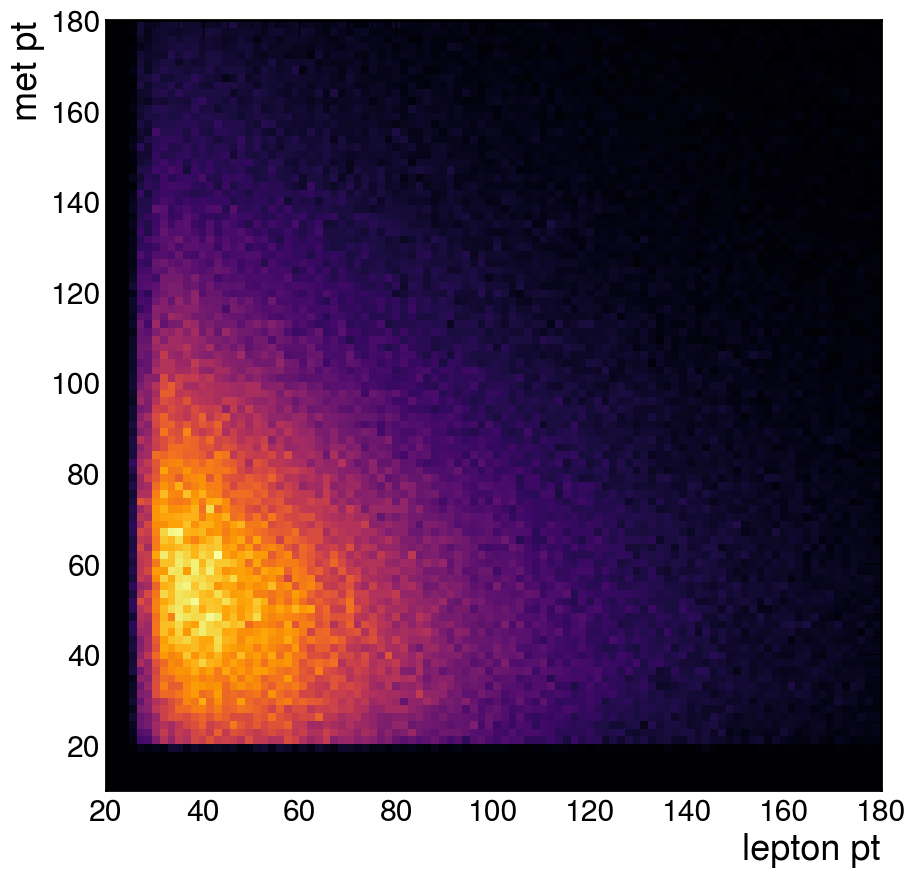

In [30]:
plt.hist(lepton_reco.pt, bins=100, range=(0,400), label="lepton pt", histtype="step")
plt.hist(met.pt, bins=100, range=(0,400), label="met pt", histtype="step")
plt.legend()
plt.show()

plt.hist2d(np.asarray(lepton_reco.pt), np.asarray(met.pt), bins=(100,100), range=[[20, 180], [10, 180]], cmap="inferno")
plt.xlabel("lepton pt"); plt.ylabel("met pt")
plt.show()

# Invariant mass of lepton & MET

In [ ]:
summed_reco = lepton_reco + met
plt.hist(summed_reco.mass, bins=150, range=(0, 400), color="darkorange")
plt.show()

# Correlations between final boost (jets only) and lepton

In [ ]:
plt.hist(boost_jets.pt, bins=100, range=(0,400), label="boost pt", histtype="step")
plt.hist(lepton_reco.pt, bins=100, range=(0,400), label="lepton pt", histtype="step")
plt.legend()
plt.show()

plt.hist2d(boost_jets.pt, lepton_reco.pt, bins=(200,200), range=[[0, 200], [10, 200]], cmap="inferno")
plt.xlabel("boost pt"); plt.ylabel("lepton pt")
plt.show()

In [ ]:
plt.hist(boost_jets.eta, bins=100, range=(-3, 3), label="boost eta", histtype="step")
plt.hist(lepton_reco.eta, bins=100, range=(-3, 3), label="lepton eta", histtype="step")
plt.legend()
plt.show()

plt.hist2d(boost_jets.eta, lepton_reco.eta, bins=(200,200), range=[[-5, 5], [-3, 3]], cmap="inferno")
plt.xlabel("boost eta"); plt.ylabel("lepton eta")
plt.show()

In [ ]:
plt.hist(boost_jets.phi, bins=100, range=(-4, 4), label="boost phi", histtype="step")
plt.hist(lepton_reco.phi, bins=100, range=(-4, 4), label="lepton phi", histtype="step")
plt.legend()
plt.show()

plt.hist2d(boost_jets.phi, lepton_reco.phi, bins=(200,200), cmap="inferno")
plt.xlabel("boost phi"); plt.ylabel("lepton phi")
plt.show()

In [ ]:
plt.hist(boost_jets.px, bins=100, range=(-500, 500), label="boost px", histtype="step")
plt.hist(lepton_reco.px, bins=100, range=(-500, 500), label="lepton px", histtype="step")
plt.legend()
plt.show()

plt.hist2d(boost_jets.px, lepton_reco.px, bins=(200,200), range=[[-300,300], [-200,200]], cmap="inferno")
plt.xlabel("boost px"); plt.ylabel("lepton px")
plt.show()

In [ ]:
plt.hist(boost_jets.py, bins=100, range=(-500, 500), label="boost py", histtype="step")
plt.hist(lepton_reco.py, bins=100, range=(-500, 500), label="lepton py", histtype="step")
plt.legend()
plt.show()

plt.hist2d(boost_jets.py, lepton_reco.py, bins=(200,200), range=[[-300,300], [-200,200]], cmap="inferno")
plt.xlabel("boost py"); plt.ylabel("lepton py")
plt.show()

In [ ]:
plt.hist(boost_jets.pz, bins=100, range=(-1000, 1000), label="boost pz", histtype="step")
plt.hist(lepton_reco.pz, bins=100, range=(-1000, 1000), label="lepton pz", histtype="step")
plt.legend()
plt.show()

plt.hist2d(boost_jets.pz, lepton_reco.pz, bins=(200,200), range=[[-1000,1000], [-200,200]], cmap="inferno")
plt.xlabel("boost pz"); plt.ylabel("lepton pz")
plt.show()

# Correlations between initial energies and total boost

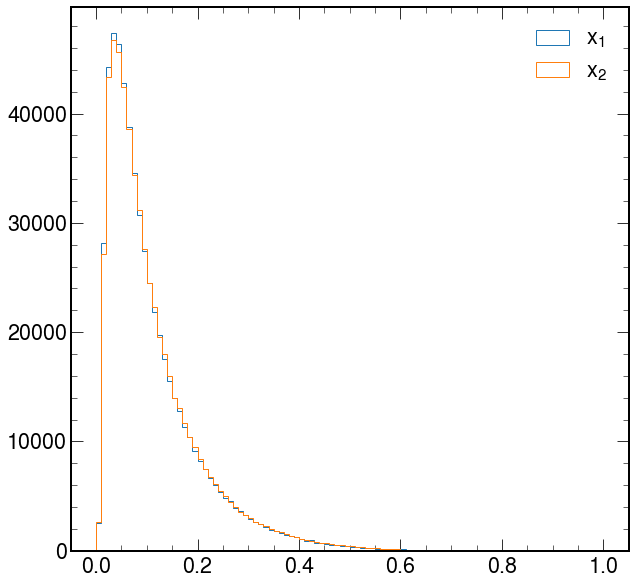

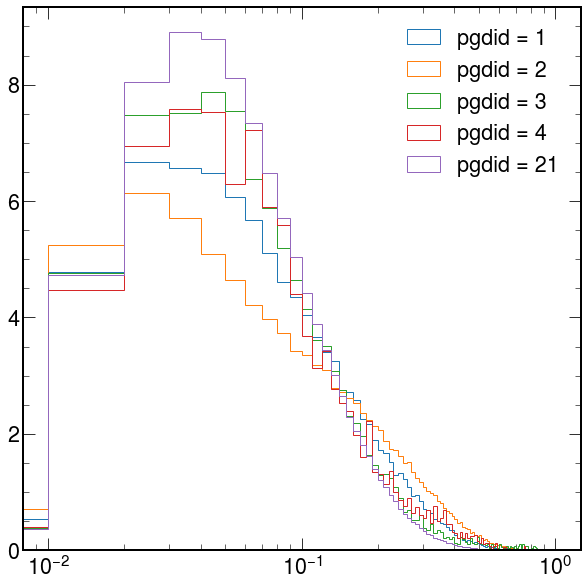

In [14]:
plt.hist(generator_info.x1, bins=100, label=r"$x_1$", range=(0, 1), histtype="step")
plt.hist(generator_info.x2, bins=100, label=r"$x_2$",range=(0, 1), histtype="step")
plt.legend()
plt.show()

for i in range(22):
    energies = generator_info[abs(generator_info.pdgid1) == i].x1
    if len(energies)  > 3000:
        plt.hist(energies, bins=100, label=f"pgdid = {i}", range=(0, 1), histtype="step", density=True)
plt.legend()
plt.xscale("log")
plt.show()


In [11]:
#TASK: Define a 4-vector of the initial energy with pz = 6500*x1 - 6500*x2. Compare it to the total boost in all aspects.

initial_pz = 6500*(generator_info.x1 - generator_info.x2)
initial_E = 6500*(generator_info.x1 + generator_info.x2)

initial_boost = ak.Array(
    {"px": np.zeros_like(initial_pz), "py": np.zeros_like(initial_pz), "pz": initial_pz, "E": initial_E},
    with_name="Momentum4D"
)
initial_boost.type

584143 * Momentum4D["px": float32, "py": float32, "pz": float32, "E": float32]

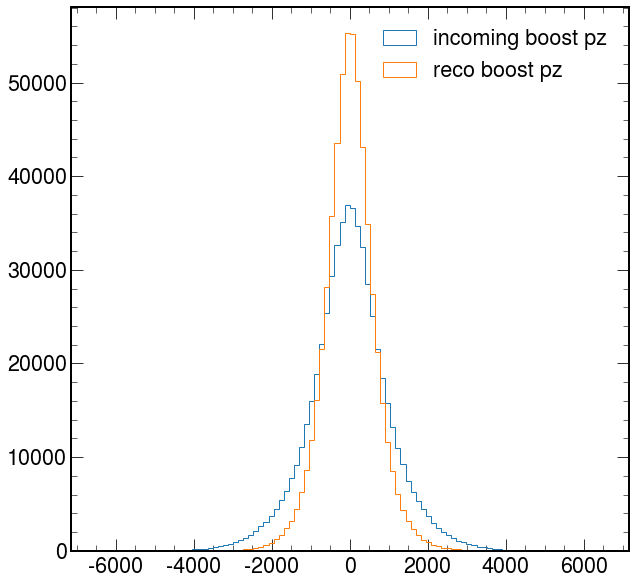

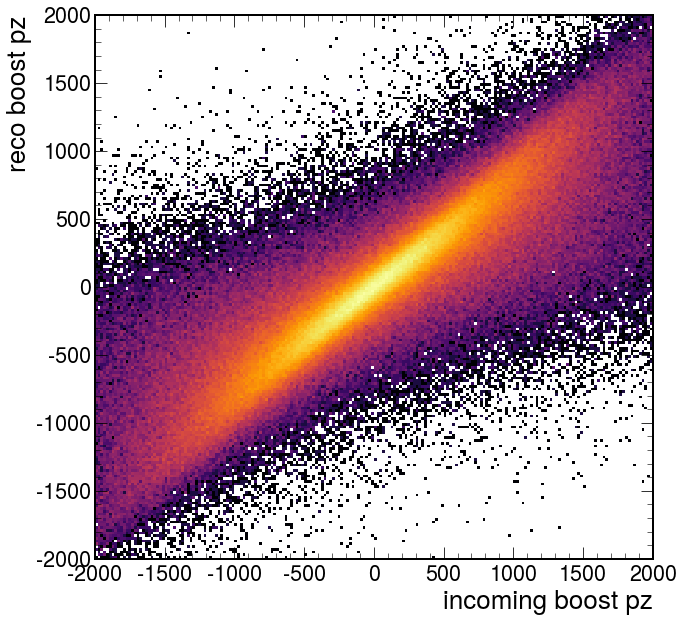

In [15]:
plt.hist(initial_boost.pz, bins=100, range=(-6500, 6500), label="incoming boost pz", histtype="step")
plt.hist(boost_reco.pz, bins=100, range=(-6500, 6500), label="reco boost pz", histtype="step")
plt.legend()
plt.show()

plt.hist2d(initial_boost.pz, boost_reco.pz, bins=(200,200), range=[[-2000,2000], [-2000,2000]], cmap="inferno", norm=LogNorm())
plt.xlabel("incoming boost pz"); plt.ylabel("reco boost pz")
plt.show()

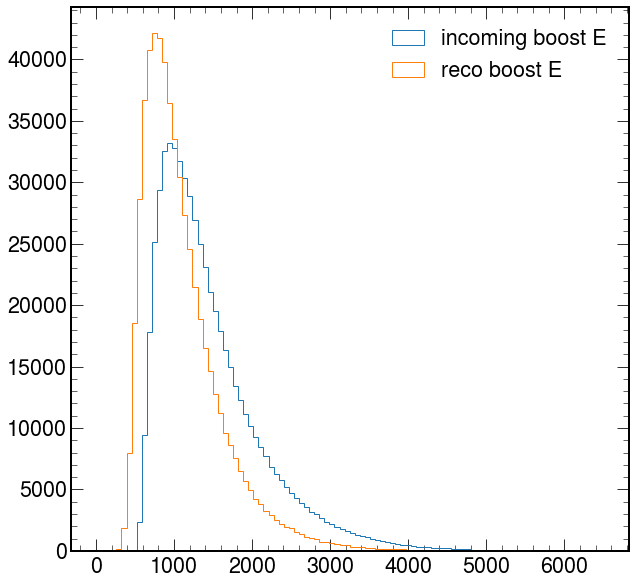

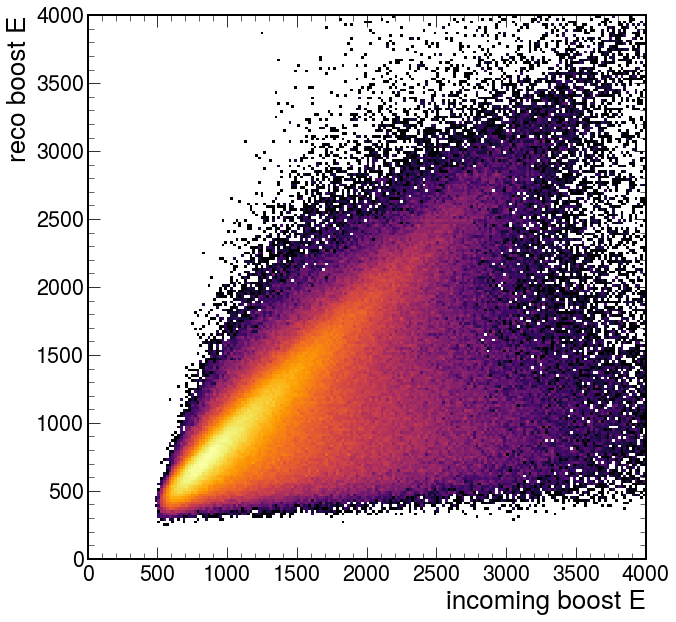

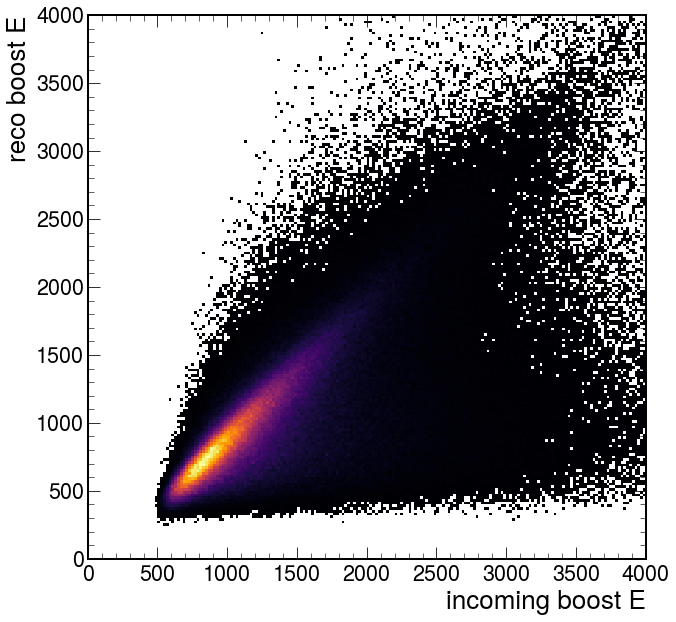

In [21]:
plt.hist(initial_boost.E, bins=100, range=(0, 6500), label="incoming boost E", histtype="step")
plt.hist(boost_reco.E, bins=100, range=(0, 6500), label="reco boost E", histtype="step")
plt.legend()
plt.show()

plt.hist2d(initial_boost.E, boost_reco.E, bins=(200,200), range=[[0,4000], [0,4000]], cmap="inferno", norm=LogNorm())
plt.xlabel("incoming boost E"); plt.ylabel("reco boost E")
plt.show()

plt.hist2d(initial_boost.E, boost_reco.E, bins=(200,200), range=[[0,4000], [0,4000]], cmap="inferno", cmin=1)
plt.xlabel("incoming boost E"); plt.ylabel("reco boost E")
plt.show()

# Correlation between parton boost and final reconstructed boost

In [35]:
#Task: Define total parton sum by adding partons_matched with lepton_partons

#Three boosts to compare: initial_boost, parton_boost, boost_reco
parton_boost_nolepton = get_vector_sum(partons)
parton_boost_lepton = get_vector_sum(lepton_partons)
parton_boost = parton_boost_nolepton + parton_boost_lepton

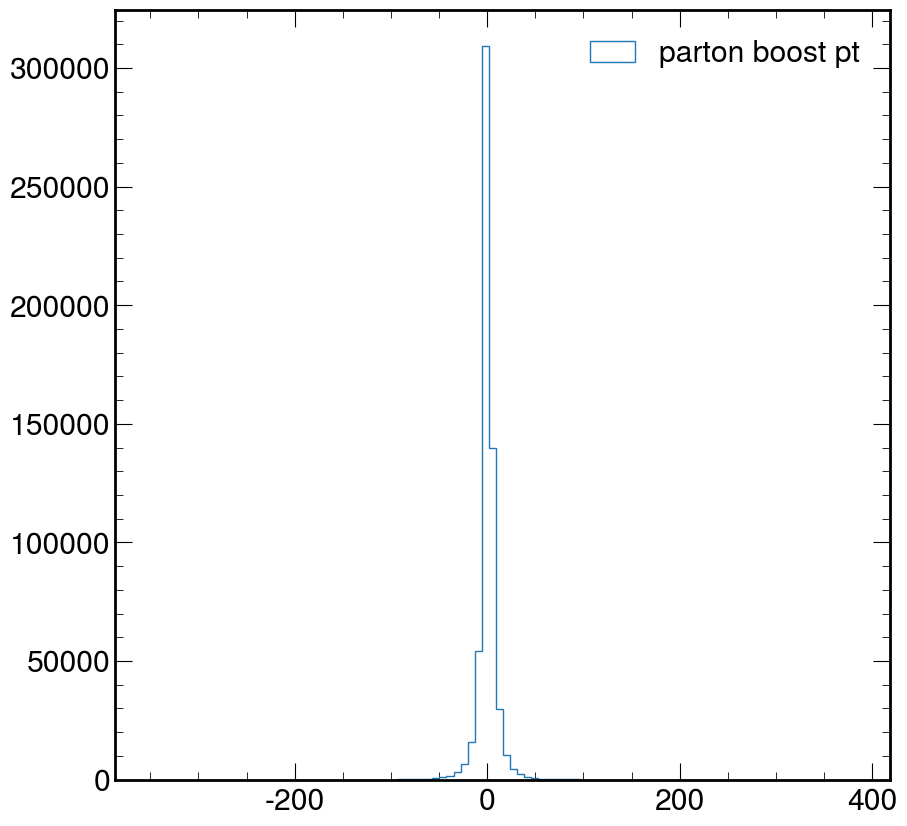

In [41]:
plt.hist(parton_boost.py, bins=100, label="parton boost pt", histtype="step")
#plt.hist(boost_reco.pt, bins=100, range=(0,400), label="final boost pt", histtype="step")
plt.legend()
plt.show()

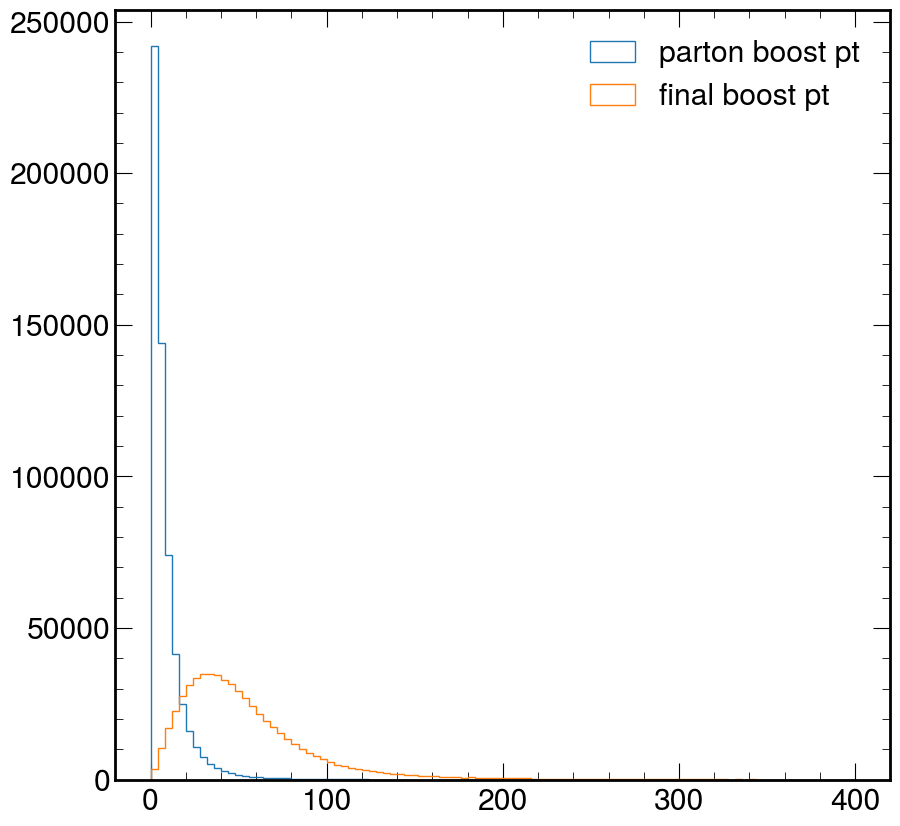

AttributeError: no field named 'T'

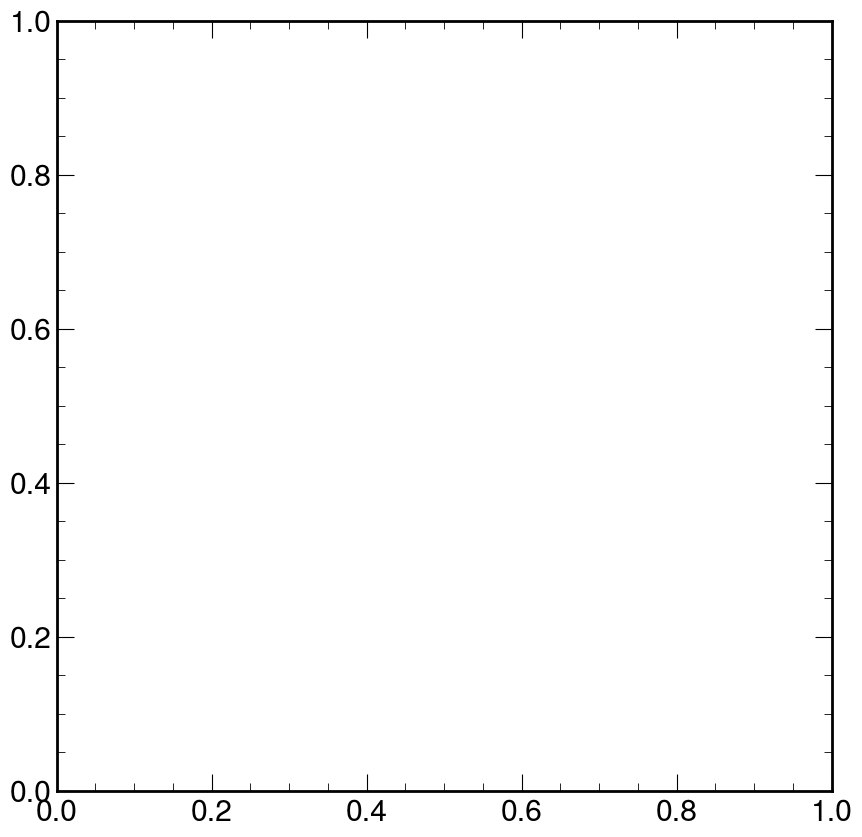

In [36]:
plt.hist(parton_boost.pt, bins=100, range=(0,400), label="parton boost pt", histtype="step")
plt.hist(boost_reco.pt, bins=100, range=(0,400), label="final boost pt", histtype="step")
plt.legend()
plt.show()

plt.hist2d(parton_boost.pt, boost_reco.pt, bins=(200,200), range=[[0, 100], [0, 100]], cmap="inferno", norm=LogNorm())
plt.xlabel("parton boost pt"); plt.ylabel("final boost pt")
plt.show()

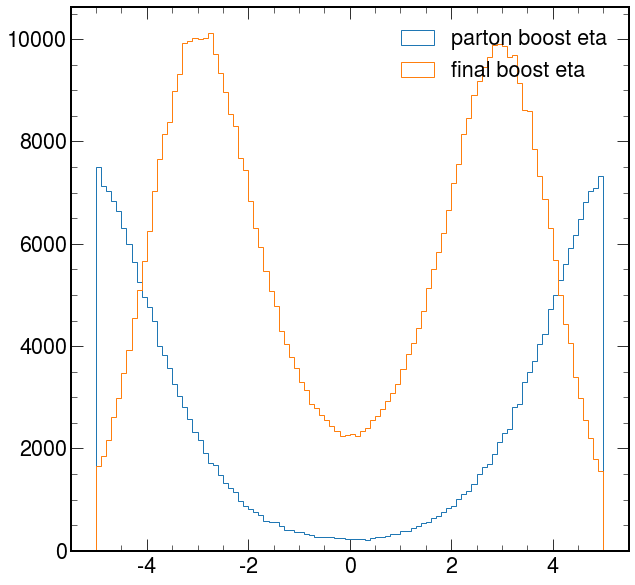

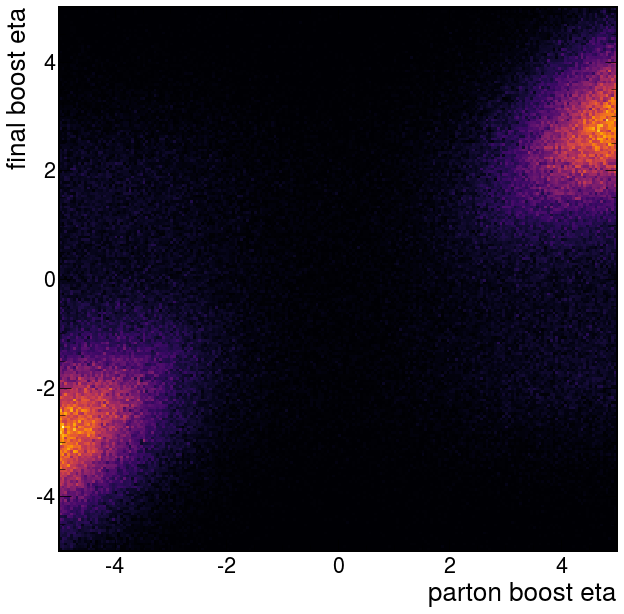

In [26]:
plt.hist(parton_boost.eta, bins=100, range=(-5, 5), label="parton boost eta", histtype="step")
plt.hist(boost_reco.eta, bins=100, range=(-5, 5), label="final boost eta", histtype="step")
plt.legend()
plt.show()

plt.hist2d(parton_boost.eta, boost_reco.eta, bins=(200,200), range=[[-5, 5], [-5, 5]], cmap="inferno")
plt.xlabel("parton boost eta"); plt.ylabel("final boost eta")
plt.show()

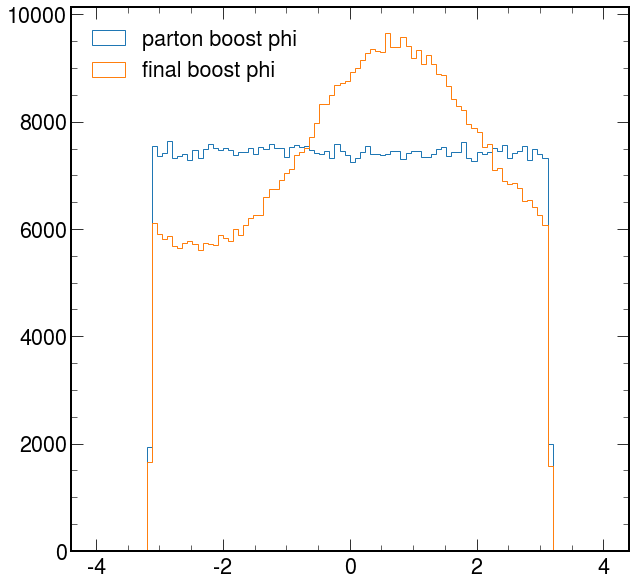

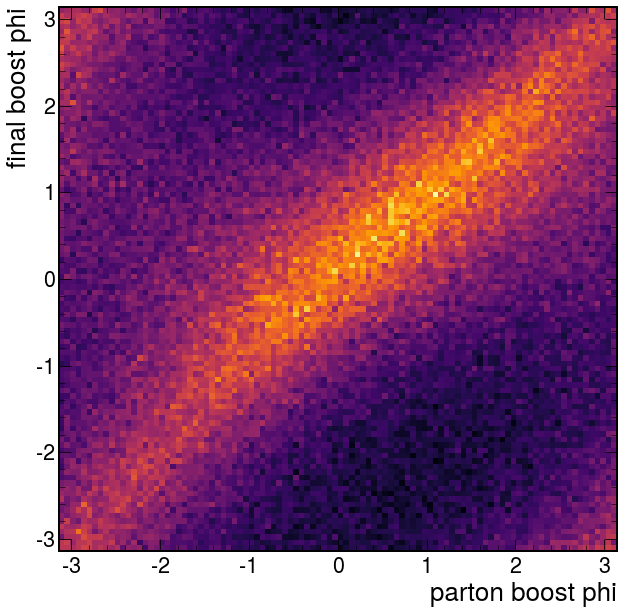

In [27]:
plt.hist(parton_boost.phi, bins=100, range=(-4, 4), label="parton boost phi", histtype="step")
plt.hist(boost_reco.phi, bins=100, range=(-4, 4), label="final boost phi", histtype="step")
plt.legend(loc="upper left")
plt.show()

plt.hist2d(parton_boost.phi, boost_reco.phi, bins=(100,100), cmap="inferno")
plt.xlabel("parton boost phi"); plt.ylabel("final boost phi")
plt.show()

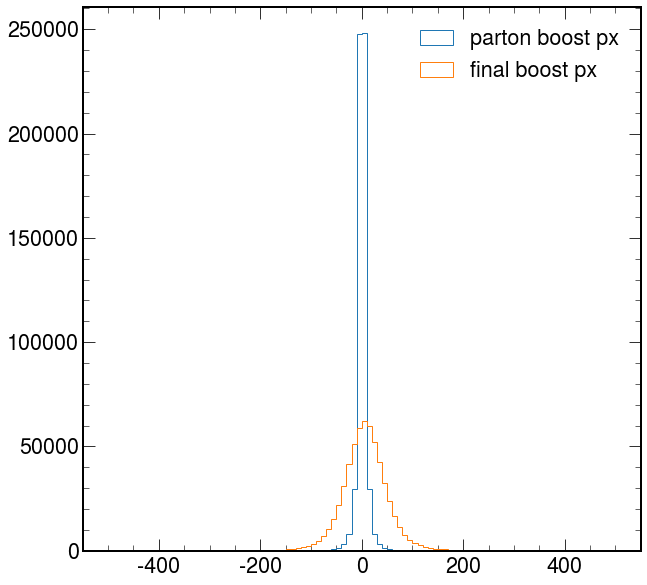

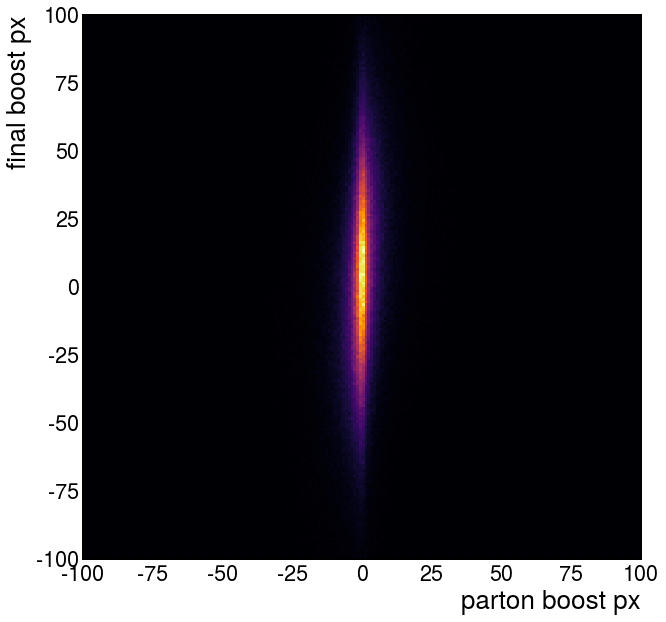

In [28]:
plt.hist(parton_boost.px, bins=100, range=(-500, 500), label="parton boost px", histtype="step")
plt.hist(boost_reco.px, bins=100, range=(-500, 500), label="final boost px", histtype="step")
plt.legend()
plt.show()

plt.hist2d(parton_boost.px, boost_reco.px, bins=(200,200), range=[[-100,100], [-100,100]], cmap="inferno")
plt.xlabel("parton boost px"); plt.ylabel("final boost px")
plt.show()

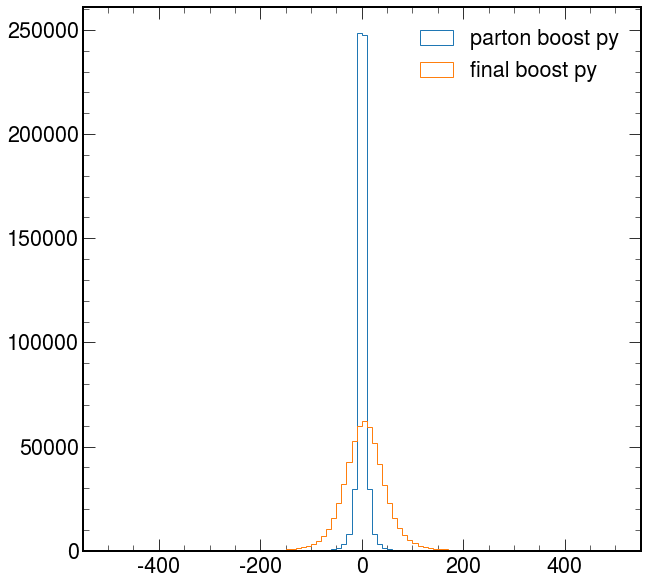

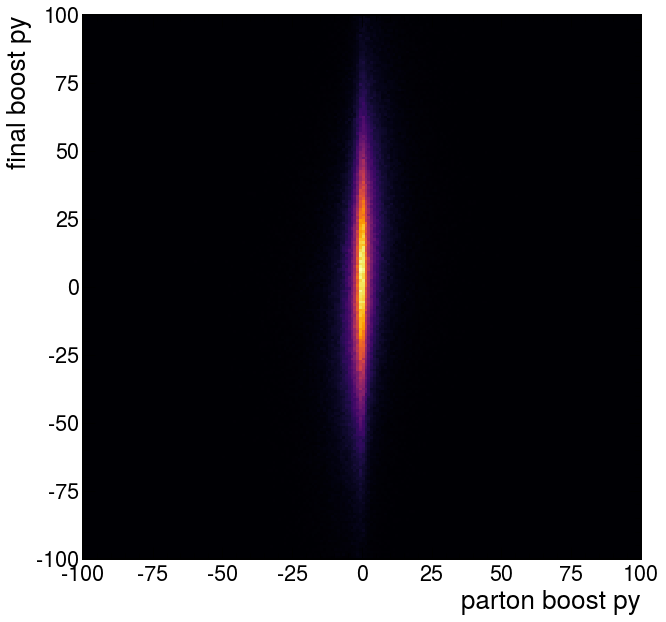

In [29]:
plt.hist(parton_boost.py, bins=100, range=(-500, 500), label="parton boost py", histtype="step")
plt.hist(boost_reco.py, bins=100, range=(-500, 500), label="final boost py", histtype="step")
plt.legend()
plt.show()

plt.hist2d(parton_boost.py, boost_reco.py, bins=(200,200), range=[[-100,100], [-100,100]], cmap="inferno")
plt.xlabel("parton boost py"); plt.ylabel("final boost py")
plt.show()

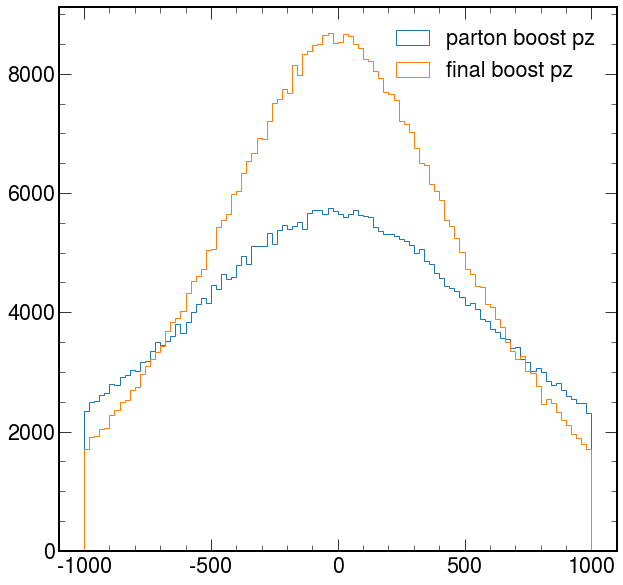

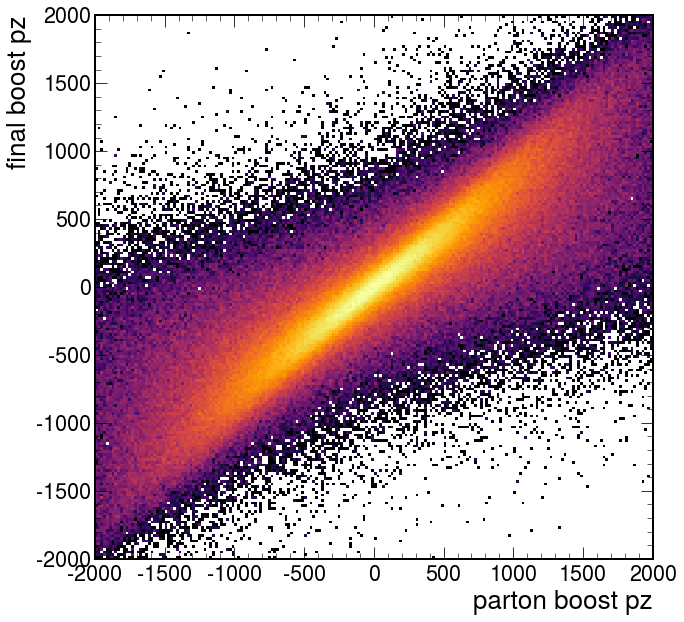

In [30]:
plt.hist(parton_boost.pz, bins=100, range=(-1000, 1000), label="parton boost pz", histtype="step")
plt.hist(boost_reco.pz, bins=100, range=(-1000, 1000), label="final boost pz", histtype="step")
plt.legend()
plt.show()

plt.hist2d(parton_boost.pz, boost_reco.pz, bins=(200,200), range=[[-2000,2000], [-2000,2000]], cmap="inferno", norm=LogNorm())
plt.xlabel("parton boost pz"); plt.ylabel("final boost pz")
plt.show()

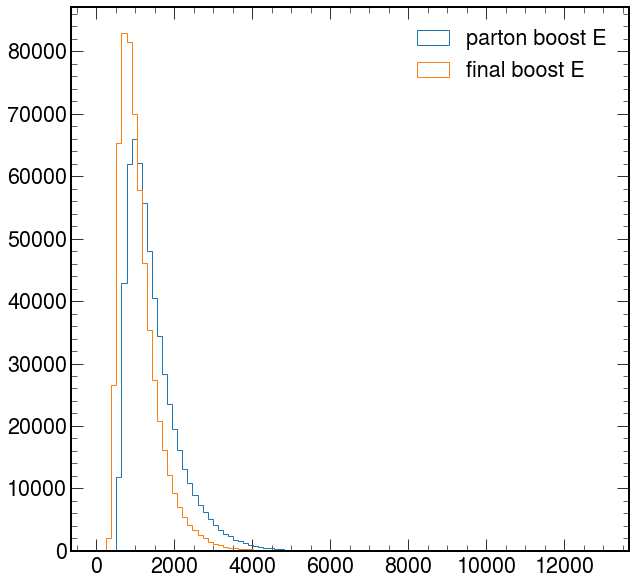

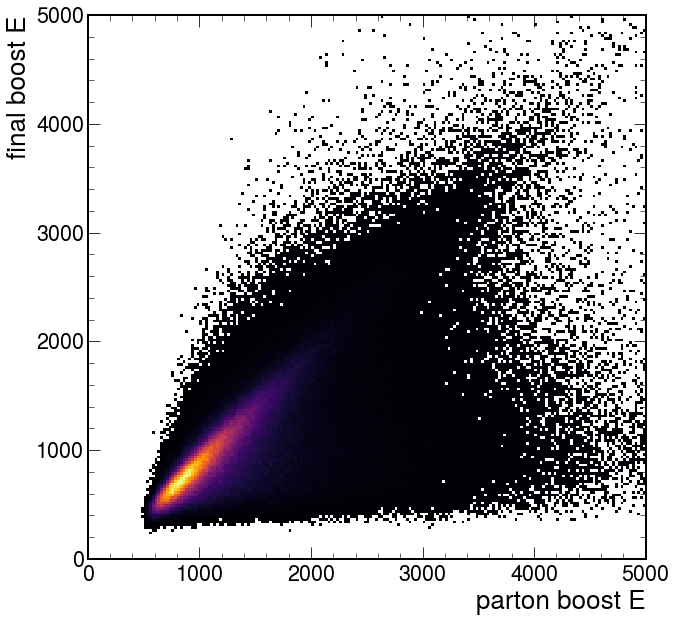

In [31]:
plt.hist(parton_boost.E, bins=100, range=(0, 13000), label="parton boost E", histtype="step")
plt.hist(boost_reco.E, bins=100, range=(0, 13000), label="final boost E", histtype="step")
plt.legend()
plt.show()

plt.hist2d(parton_boost.E, boost_reco.E, bins=(200,200), range=[[0,5000], [0,5000]], cmap="inferno", cmin=1)
plt.xlabel("parton boost E"); plt.ylabel("final boost E")
plt.show()

# Correlation between initial generator boost and parton boost

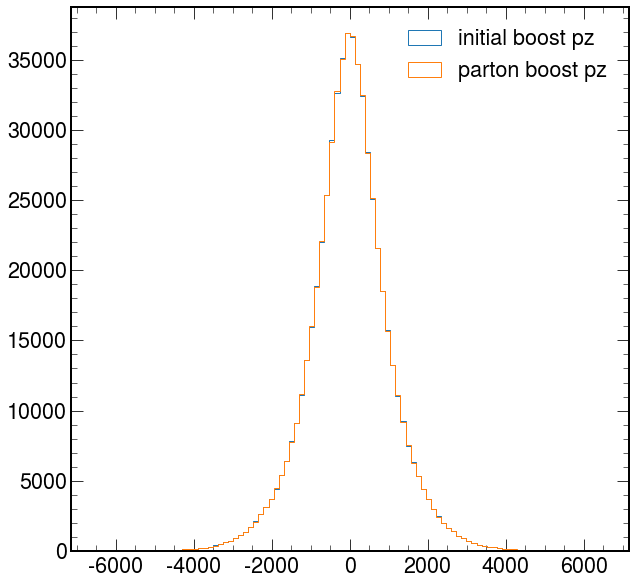

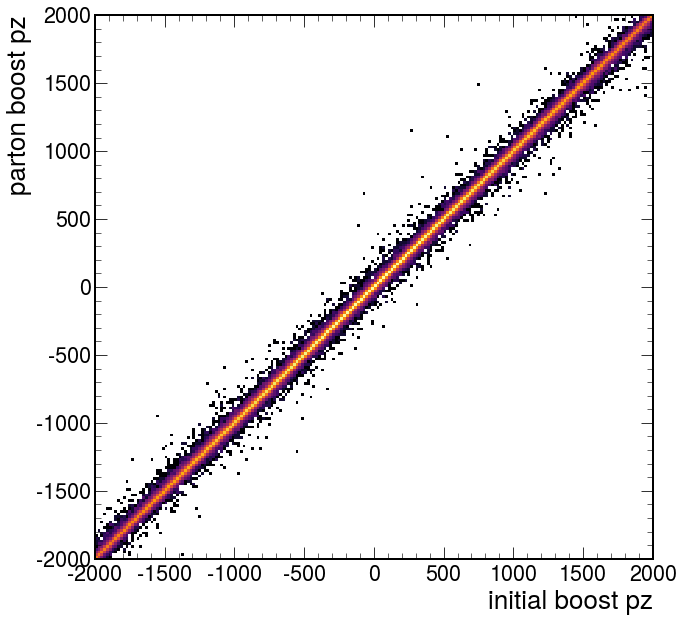

In [34]:
plt.hist(initial_boost.pz, bins=100, range=(-6500, 6500), label="initial boost pz", histtype="step")
plt.hist(parton_boost.pz, bins=100, range=(-6500, 6500), label="parton boost pz", histtype="step")
plt.legend()
plt.show()

plt.hist2d(initial_boost.pz, parton_boost.pz, bins=(200,200), range=[[-2000,2000], [-2000,2000]], cmap="inferno", norm=LogNorm())
plt.xlabel("initial boost pz"); plt.ylabel("parton boost pz")
plt.show()

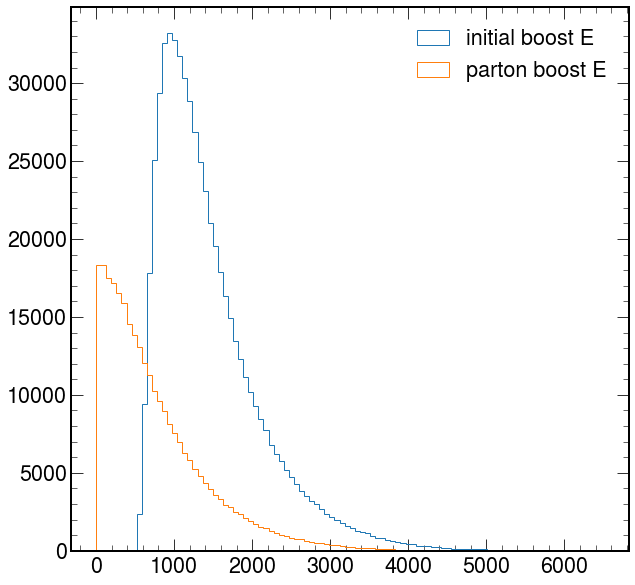

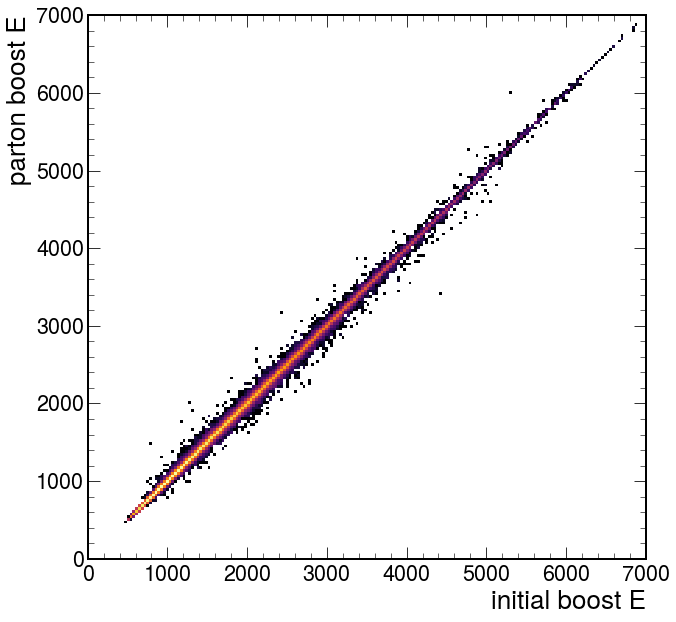

In [37]:
plt.hist(initial_boost.E, bins=100, range=(0, 6500), label="initial boost E", histtype="step")
plt.hist(parton_boost.pz, bins=100, range=(0, 6500), label="parton boost E", histtype="step")
plt.legend()
plt.show()

plt.hist2d(initial_boost.E, parton_boost.E, bins=(200,200), range=[[0,7000], [0,7000]], cmap="inferno", norm=LogNorm())
plt.xlabel("initial boost E"); plt.ylabel("parton boost E")
plt.show()